## Connect Google Colab to my Google drive 

**Note** : Do not run if ( Local computer  )

In [ ]:
# Set up the current directory
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive/Colab Notebooks/PLDAC/deezer_data 
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/PLDAC/deezer_data
/content/drive/My Drive/Colab Notebooks/PLDAC/deezer_data


# Imports

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp
import seaborn as sns
sns.set()

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import multilabel_confusion_matrix


import torch.nn as nn
import torch
import torch.optim as optim
import torch.utils.data as utils
from torchsummary import summary

import time as t 
from tabulate import tabulate

import json
import gc



pd.options.display.max_columns = 2683

# Data Preprocessing 

### Fetching data

In [ ]:
df_labels = pd.read_json ('../deezer_data/album_genres_new_releases.json' , lines = True )
df_data = pd.read_json ('../deezer_data/sampled_geoloc_counters_new_releases.json' , lines = True )

### Preparing multi-labels matrix

Assumption : Delete genre with less than 5 samples

In [ ]:
################################################ Counting  ################################################

labels_counts_df =  df_labels.groupby('genre_name',as_index=False).count().sort_values(by=['album_id'],
                                      ascending=False).reset_index(drop=True)
labels_counts_df.columns = ['Genre','Counts']

print ("The min of genre counting is : \n",labels_counts_df.min())

print("------------------------------------")

#######################################  Deleting counts < 5  ################################################

labels_counts_df_sup_5 = labels_counts_df.loc[ labels_counts_df['Counts'] >= 5 ]

df_label_merge = pd.merge(df_labels, labels_counts_df_sup_5, left_on='genre_name', right_on='Genre')

del df_label_merge['Genre']
del df_label_merge['Counts']


print("nbr de genre pauvres en données : " , labels_counts_df.shape[0] - labels_counts_df_sup_5.shape[0] )
print("nbr albums supprimés : ",  df_labels.shape[0] - df_label_merge.shape[0] )


#######################################  Binarize Labels  ################################################


df_labels = df_label_merge

binarized_df_labels = pd.get_dummies( df_labels , columns=['genre_name'] , prefix="" , prefix_sep="" )
df_multi_labels = binarized_df_labels.groupby(['album_id']  ).sum()
df_multi_labels.sort_index()

df_multi_labels.head(5)

The min of genre counting is : 
 Genre     Afro Pop
Counts           1
dtype: object
------------------------------------
nbr de genre pauvres en données :  24
nbr albums supprimés :  40


,Alternative,Chanson française,Chill Out/Trip-Hop/Lounge,Classique,Dance,Electro,Films/Jeux vidéo,Latino,Metal,Musique africaine,Musiques de films,Pop,Pop Indé,Pop internationale,Pop latine,R&B,Rap français,Rap/Hip Hop,Reggae,Rock,Rock indé,Singer & Songwriter,Soul,Soul & Funk,Techno/House,Variété Internationale,World
album_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
13972552,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13979628,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13986414,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13994594,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13994632,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Preparing  spatio-temporal data 


In [ ]:
# Deleting unecessary columns
df_data.rename(columns={'d':'date'}, inplace=True)
del df_data["age_group"]
del df_data["nstreams"]
del df_data["platform_name"]

df_data.head()

,album_id,date,loc_city,nusers
0,14171536,20161031,Paris,14
1,14171536,20170427,Paris,5
2,14171536,20161008,Paris,6
3,14171536,20161220,Levallois-perret,3
4,14171536,20170929,Strasbourg,3


In [ ]:
# Grouping albums by same ( day , city  )
print("len before grouping by city,date : ",len(df_data))
df_data = df_data.groupby(['album_id','date','loc_city'] ,as_index=False ).sum()
print("len after grouping by city,date : ",len(df_data))

len before grouping by city,date :  2348509
len after grouping by city,date :  785956


In [ ]:
# transforming the date column to datetime type
df_data['date'] = pd.to_datetime(df_data['date'],format='%Y%m%d') 
df_data['date'] = df_data['date'].dt.date

In [ ]:
df_data.head(6)

,album_id,date,loc_city,nusers
0,13972552,2016-11-03,Paris,3
1,13972552,2016-11-19,Paris,3
2,13972552,2016-11-20,Paris,3
3,13972552,2016-11-24,Paris,3
4,13972552,2016-12-09,Paris,3
5,13972552,2016-12-10,Paris,3


In [ ]:
# some stats on date column ( temporal trace )
date_min = df_data['date'].min()
date_max = df_data['date'].max()
max_trace_len = date_max - date_min 
print("Minimum date : ", date_min )
print("Maximum date : ", date_max )
print("Max trace len is :  ", max_trace_len.days + 1 ," days " ) 

Minimum date :  2016-10-07
Maximum date :  2017-09-29
Max trace len is :   358  days 


In [ ]:
# getting data in numpy format 
tab = df_data.values
# delete the pandas for the sake of memory usage
del df_data
# garbage collector
gc.collect()

68

In [ ]:
tab

array([[13972552, datetime.date(2016, 11, 3), 'Paris', 3],
       [13972552, datetime.date(2016, 11, 19), 'Paris', 3],
       [13972552, datetime.date(2016, 11, 20), 'Paris', 3],
       ...,
       [45298611, datetime.date(2017, 9, 25), 'Paris', 6],
       [45298611, datetime.date(2017, 9, 27), 'Paris', 5],
       [45298611, datetime.date(2017, 9, 28), 'Paris', 8]], dtype=object)

### Albums :  Matrix Representation => Dictionary Representation 

In [ ]:
from collections import OrderedDict


villes={}

albums=OrderedDict()


maxSize=358 

for i in range(len(tab)):
  
  a=tab[i,0]
  
  # the album has to be labeled else we don t keep it 
  if ( a in df_multi_labels.index ) :
    
    
    v=tab[i,2]
    if not v in villes:
        villes[v]=len(villes.keys())
        
    t=tab[i,1]

    # check if the album was not created before 
    if a not in albums :
      albums[a]={"id":len(albums.keys()), "startTime":t, "steps":OrderedDict()}

    steps=albums[a]["steps"]
    st=albums[a]["startTime"]
    t=(t-st).days

    if t>maxSize:
      continue

    if not t in steps:

      steps[t]={}
      step=steps[t]
      v=villes[v]
      if not v in step:
           step[v]=0

      step[v]=tab[i,3]

In [ ]:
villes

{'Paris': 0,
 'Marseille': 1,
 'Saint-ouen': 2,
 'Lyon': 3,
 'Montreuil': 4,
 'Toulouse': 5,
 'Drancy': 6,
 'Nanterre': 7,
 'Levallois-perret': 8,
 'Clamart': 9,
 'Enghien-les-bains': 10,
 'Montpellier': 11,
 'Issy-les-moulineaux': 12,
 'Alfortville': 13,
 'Villeneuve-lez-avignon': 14,
 'Joinville-le-pont': 15,
 'Asnières': 16,
 'Bagneux': 17,
 'Gennevilliers': 18,
 'Montrouge': 19,
 'Mérignac': 20,
 'Neuilly-sur-seine': 21,
 'Puteaux': 22,
 'Abymes': 23,
 'Clichy': 24,
 'Bordeaux': 25,
 'Gosier': 26,
 'Strasbourg': 27,
 'Fort-de-france': 28,
 'Les Abymes': 29,
 'Saint-brice-sous-forêt': 30,
 'Bon-encontre': 31,
 'Kremlin-bicêtre': 32,
 "L'hay-les-roses": 33,
 'Fontaine-de-vaucluse': 34,
 'Bois-colombes': 35,
 'Pointe-à-pitre': 36,
 'Nice': 37,
 'Romans-sur-isère': 38,
 'Saint-denis': 39,
 'Chevilly-larue': 40,
 'Charenton-le-pont': 41,
 'Ivry-sur-seine': 42,
 'Saint-cyr-sur-le-rhône': 43,
 'Palaiseau': 44,
 'Courbevoie': 45,
 'Carpentras': 46,
 'Saint-sardos': 47,
 'Vitry-sur-seine': 

In [ ]:
albums[13972552]

{'id': 0,
 'startTime': datetime.date(2016, 11, 3),
 'steps': OrderedDict([(0, {0: 3}),
              (16, {0: 3}),
              (17, {0: 3}),
              (21, {0: 3}),
              (36, {0: 3}),
              (37, {0: 3}),
              (52, {0: 3}),
              (56, {0: 3}),
              (58, {1: 3}),
              (63, {0: 3}),
              (66, {0: 3}),
              (67, {2: 3}),
              (71, {0: 8}),
              (73, {0: 4}),
              (75, {0: 3}),
              (77, {0: 3}),
              (82, {0: 3}),
              (83, {0: 3}),
              (84, {0: 3}),
              (85, {0: 5}),
              (95, {0: 3}),
              (96, {0: 3}),
              (98, {0: 3}),
              (102, {0: 5}),
              (108, {0: 3}),
              (120, {0: 3}),
              (136, {0: 3}),
              (142, {0: 6}),
              (149, {0: 3}),
              (153, {0: 3}),
              (155, {0: 9}),
              (156, {0: 5}),
              (163, {0: 3}),
      

In [ ]:
# genre mapping dictionary

genres = list( df_multi_labels.columns )

dic_labs_mapping = { i : genres[i]  for i in range ( len(genres) )}

dic_labs_mapping

{0: 'Alternative',
 1: 'Chanson française',
 2: 'Chill Out/Trip-Hop/Lounge',
 3: 'Classique',
 4: 'Dance',
 5: 'Electro',
 6: 'Films/Jeux vidéo',
 7: 'Latino',
 8: 'Metal',
 9: 'Musique africaine',
 10: 'Musiques de films',
 11: 'Pop',
 12: 'Pop Indé',
 13: 'Pop internationale',
 14: 'Pop latine',
 15: 'R&B',
 16: 'Rap français',
 17: 'Rap/Hip Hop',
 18: 'Reggae',
 19: 'Rock',
 20: 'Rock indé',
 21: 'Singer & Songwriter',
 22: 'Soul',
 23: 'Soul & Funk',
 24: 'Techno/House',
 25: 'Variété Internationale',
 26: 'World'}

### Display an album trace over time

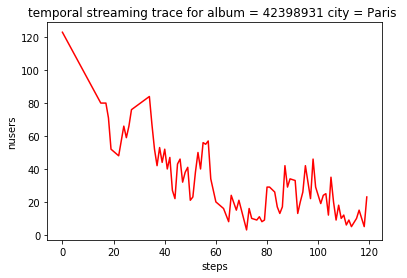

In [ ]:
steps = albums[42398931]["steps"]
# 0 ==> Paris 
nusers_Paris_Album = { t:  steps[t][v]  for t in steps if 0 in steps[t]  }

plt.plot(list( nusers_Paris_Album.keys()) , list(nusers_Paris_Album.values()) ,'r' )
plt.title ("temporal streaming trace for album = 42398931 city = Paris ")
plt.xlabel("steps")
plt.ylabel("nusers")
plt.show()

# Global Functions

In [ ]:
def  Custom_Train_Test_Split ( X , Y , training_percent = 0.6 ) : 
  
    '''
    
    a function that splits data respecting the training_percent for each label 
    ==> it keeps the same distribution as the training 
    
    '''
    
    np.random.seed(1234)
    #Pre condition
    training_percent = min(1,max(0,training_percent))

    classes = Y.T
    args_train = set() 
    args_test = set()
    
    
    for class_row in classes : 
      
      args = np.where( class_row ==  1 )[0]
      np.random.shuffle(args)
      i = int( args.shape[0]*training_percent )  

      args_train = args_train.union( set( list(args[ : i ]) )  )
      args_test = args_test.union( set( list(args[ i :  ]) )  )


      
      
    args_train , args_test = np.array( list(args_train) ) , np.array( list(args_test) )
    
    training_data,training_labels , test_data,test_labels = X[args_train],Y[args_train],X[args_test],Y[args_test] 
    
    return training_data , training_labels , test_data , test_labels

# PYTORCH

## Baseline  nbSteps=1

In [ ]:
# number of aggregated groups 
nbSteps=1
stepSize=np.ceil(maxSize/nbSteps)


# albums index array 
ialbums=[""]*len(albums.keys())   


data=np.zeros( ( len(albums.keys()) , nbSteps , len(villes.keys())  ) ,dtype="int16" )

    
gc.collect()

2748

In [ ]:
print("Albums ordered Confirmation ( Expected = 1537 ) <=> ( Found =",  ( np.array ( df_multi_labels.index ) == np.array( list(albums.keys()) ) ).sum(),")" )  


Albums ordered Confirmation ( Expected = 1537 ) <=> ( Found = 1537 )


In [ ]:
%%time

for a in albums :
  
  
  ialbums[albums[a]["id"]]=a
  
  steps=albums[a]["steps"]

  vals= np.zeros( ( nbSteps , len(villes.keys()) ) , dtype="int16" )

  for step in steps :  
    
    villes_dict =steps[step]
    
    group = int ( step // stepSize )

    for ville in villes_dict:
      
      vals[ group , ville ]+= villes_dict[ville]
      
      data[albums[a]["id"]]=vals

CPU times: user 964 ms, sys: 4.47 ms, total: 968 ms
Wall time: 971 ms


In [ ]:
data.shape

(1537, 1, 2683)

### Visualizing

In [ ]:
X = np.array ( [[0,0],[0,1], [1,1] ,[1,0]] ) 



array([0, 0, 1])

Text(0.5, 1.0, 'Multi Label Data visualization Example')

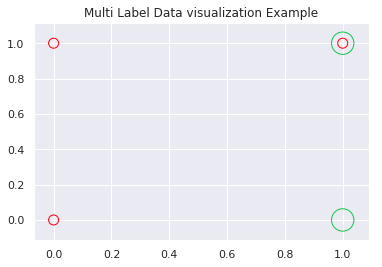

In [ ]:


plt.scatter ( X[:3,0] , X[:3,1] , s = 100 , facecolors='none',
                    edgecolors='#ff0015' )

plt.scatter ( X[2:,0] , X[2:,1] , s = 500 , facecolors='none',
                    edgecolors='#15c44f' )

plt.title("Multi Label Data visualization Example")

PCA :

In [ ]:
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8',
          '#f58231', '#911eb4', '#46f0f0', '#f032e6',
          '#bcf60c', '#fabebe', '#008080', '#e6beff',
          '#9a6324', '#fffac8', '#800000', 'red',
          '#808000', '#ffd8b1', '#000075', '#808080',
          '#000000', '#41f4b5', '#4324bf', '#31ce0e', '#ce0dbe' , '#ff0000' ,'#156b63' ]

len(colors)

27

In [ ]:
from sklearn.decomposition import PCA

X = data.reshape ( -1 , len(villes) )


pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

df = pd.DataFrame()

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 


print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

dd = df.values
labels = df_multi_labels.values

Explained variation per principal component: [0.93428375 0.04567319]


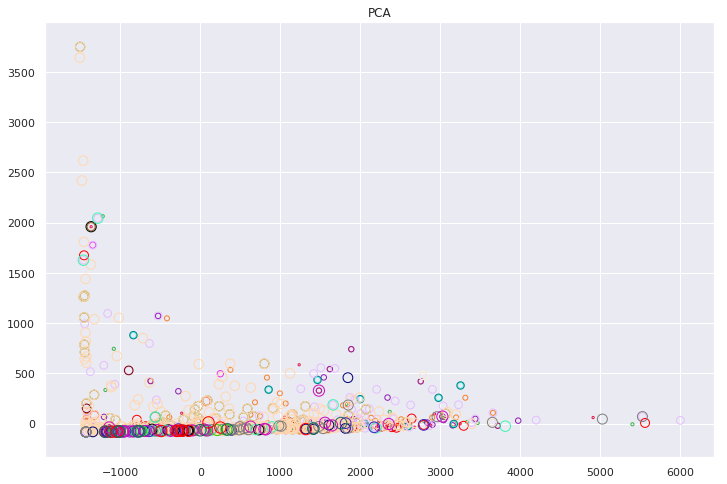

In [ ]:

plt.figure(figsize=(12,8))
s = 5 
for label in dic_labs_mapping : 
      
      a = labels [:,label]
      args = np.argwhere( a ==  1 ).ravel()
      plt.scatter ( dd[args,0] , dd[args,1] , s = s , facecolors='none',
                    edgecolors=colors[label]  )
      s += 5
      
plt.title("PCA")

plt.show()
      

In [ ]:
from sklearn.manifold import TSNE


X = data.reshape ( -1 , len(villes) )


tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(X)

df = pd.DataFrame()

df['tsne-one'] = tsne_result[:,0]
df['tsne-two'] = tsne_result[:,1] 
dd = df.values
labels = df_multi_labels.values


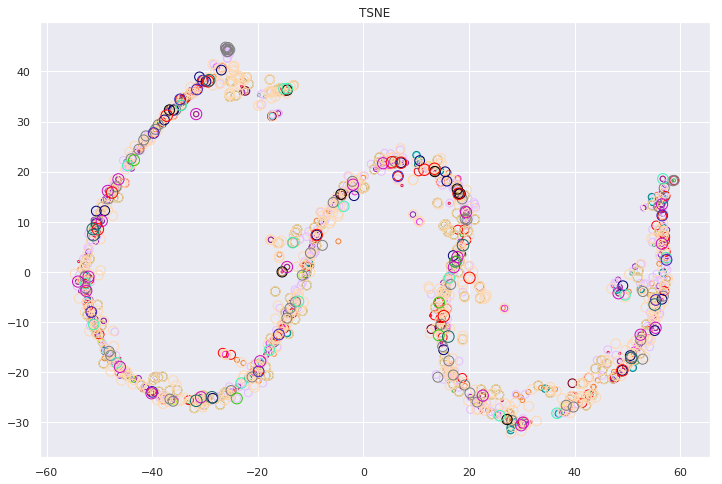

In [ ]:


plt.figure(figsize=(12,8))
s = 5 
for label in dic_labs_mapping : 
      
      a = labels [:,label]
      args = np.argwhere( a ==  1 ).ravel()
      plt.scatter ( dd[args,0] , dd[args,1] , s = s , facecolors='none',
                    edgecolors=colors[label]  )
      
      s += 5 
      
plt.title('TSNE')

plt.show()

### Train and Test on the whole Data just to get an idea !

train :

Epoch [1/50], Step [50/77], Loss: 0.2035
Epoch [2/50], Step [50/77], Loss: 0.2139
Epoch [3/50], Step [50/77], Loss: 0.1438
Epoch [4/50], Step [50/77], Loss: 0.1636
Epoch [5/50], Step [50/77], Loss: 0.1827
Epoch [6/50], Step [50/77], Loss: 0.1257
Epoch [7/50], Step [50/77], Loss: 0.1135
Epoch [8/50], Step [50/77], Loss: 0.2180
Epoch [9/50], Step [50/77], Loss: 0.1151
Epoch [10/50], Step [50/77], Loss: 0.1286
Epoch [11/50], Step [50/77], Loss: 0.1915
Epoch [12/50], Step [50/77], Loss: 0.1632
Epoch [13/50], Step [50/77], Loss: 0.1489
Epoch [14/50], Step [50/77], Loss: 0.1022
Epoch [15/50], Step [50/77], Loss: 0.1310
Epoch [16/50], Step [50/77], Loss: 0.1815
Epoch [17/50], Step [50/77], Loss: 0.0934
Epoch [18/50], Step [50/77], Loss: 0.1694
Epoch [19/50], Step [50/77], Loss: 0.1002
Epoch [20/50], Step [50/77], Loss: 0.1280
Epoch [21/50], Step [50/77], Loss: 0.1189
Epoch [22/50], Step [50/77], Loss: 0.1854
Epoch [23/50], Step [50/77], Loss: 0.1111
Epoch [24/50], Step [50/77], Loss: 0.1083
E

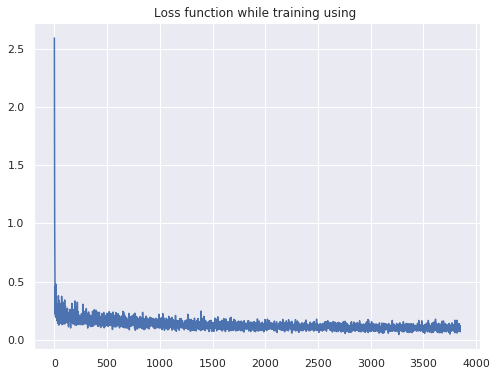

CPU times: user 6.41 s, sys: 426 ms, total: 6.84 s
Wall time: 6.74 s


In [ ]:
%%time

#data

data = data.reshape(len(albums),-1)
labels = df_multi_labels.values


gc.collect()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
input_size = data.shape[1]
hidden_size = 100
num_classes = len(genres)
num_epochs = 50
batch_size = 20
learning_rate = 0.001

# Creating a custom dataset
my_dataset = utils.TensorDataset( torch.from_numpy(data)
                                 ,torch.from_numpy(labels) )

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=my_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
  
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = NeuralNet().float().to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam( model.parameters() , lr=learning_rate ) 


# for loss visualization 
general_loss = []

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
  
    for i, (inputs,labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        inputs = inputs.view(-1 ,input_size ).float().to(device)
        labels = labels.view(-1 , num_classes ).float().to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        
        loss = criterion(outputs, labels)
        general_loss.append ( loss )
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 50 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 

                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
      
plt.figure(figsize=(8,6))
plt.plot(general_loss)
plt.title("Loss function while training using ")


plt.show()

test on training set :

In [ ]:
# Data 
data = data.reshape(len(albums),-1)
labels = df_multi_labels.values

Threshold = 0.2

soft_acc , hard_acc , hamming_score , all_pred , real_result = [] , [] , [] , [] , []

for i in range( data.shape[0] ) : 
 
  res = torch.sigmoid ( model( torch.from_numpy ( data[i] ).float().to(device)  ) )


  y_pred = (res > Threshold).cpu().numpy()
  y_true = labels[i]
  
    
  
  real_result.append ( res.detach().cpu().numpy() )  
  all_pred.append(y_pred)
  
  true_args = ( np.argwhere ( y_true == 1 ).flatten() )
  pred_args = ( np.argwhere ( y_pred == 1 ).flatten() )
  
  if ( pred_args.shape[0] == 0 ):
    pred_args = np.array ( [torch.max(res, 0)[1].cpu().item()] )
   

  
  genres_predicted = [ dic_labs_mapping[k]  for k in dic_labs_mapping if k in pred_args ]
  print("genre predicted example ",i," : ",genres_predicted)
  counts = np.array([1 for y in pred_args if y in true_args ]).sum()
  div = true_args.shape[0]
  
  soft_acc.append ( counts / div )
  hard_acc.append ( int( np.array_equal( true_args , pred_args ) ) )
  hamming_score.append( len( set(true_args).intersection(set(pred_args)) ) / len(set(true_args).union(set(pred_args))) )
  
  
soft_acc , hard_acc , hamming_score , all_pred , real_result    = \
np.array(soft_acc) ,  np.array (hard_acc) , np.array(hamming_score) , np.array (all_pred)  , np.array(real_result)

# soft accuracy : for each example   : count ( using ones in our sparse vectors )  predicted_classes / all_target_classes 



genre predicted example  0  :  ['Pop', 'Rap/Hip Hop']
genre predicted example  1  :  ['Pop', 'Rap/Hip Hop']
genre predicted example  2  :  ['Pop', 'Rap français', 'Rap/Hip Hop']
genre predicted example  3  :  ['Pop', 'Rap/Hip Hop']
genre predicted example  4  :  ['Pop', 'Rap/Hip Hop']
genre predicted example  5  :  ['Pop', 'Rap/Hip Hop']
genre predicted example  6  :  ['Pop', 'Rap/Hip Hop']
genre predicted example  7  :  ['Pop', 'Rap/Hip Hop']
genre predicted example  8  :  ['Pop', 'Rap/Hip Hop']
genre predicted example  9  :  ['Rap/Hip Hop']
genre predicted example  10  :  ['Pop', 'Rap français', 'Rap/Hip Hop']
genre predicted example  11  :  ['Pop', 'Rap/Hip Hop']
genre predicted example  12  :  ['Rap/Hip Hop']
genre predicted example  13  :  ['Rap/Hip Hop']
genre predicted example  14  :  ['Pop', 'Rap/Hip Hop']
genre predicted example  15  :  ['Dance', 'Pop']
genre predicted example  16  :  ['Pop', 'Rap/Hip Hop']
genre predicted example  17  :  ['Pop', 'Rap/Hip Hop']
genre predicted

**showing results and metrics :**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

rows = []
for lab in range( num_classes ) :
  
  y_true = labels[ : , lab ]
  y_pred = all_pred[ : , lab ]
  res =   real_result[: , lab ]
  
  rows . append ([ dic_labs_mapping[lab] ,
                 round ( precision_score(y_true,y_pred) , 2 ) ,
                 round ( recall_score(y_true,y_pred) , 2 )  ,
                 round ( f1_score(y_true,y_pred) , 2 )  ,
                 round ( average_precision_score(y_true,res) , 2 )
                 ])
  
  
rows = np.array(rows)

from IPython.display import display

print("On training data . . . \n")

metrics = pd.DataFrame(rows[ : , 1: ] , index=rows[:,0] , columns=[ 'Precision\
                     (K=27) ' , 'Recall (K=27) ' , 'F1-score (K=27) ' ,"AvgP" ])
display(metrics)
stats = rows[:,1:5].astype(float)
means = np.mean( stats ,  axis=0 )
print("\n-----------------------")
print("metrics on labels : ")
print("-----------------------")
print("MAP : ",round ( means[3] , 2 ))
print ( "Precision Macro : ",round ( means[0] , 2 ) ) 
print ( "Recall Macro : ", round ( means[1] , 2 ) )
print ( "F1-score Macro : ", round ( means[2] , 2 ) )
print("-----------------------")
print("metrics on samples : ")
print("-----------------------")
print('Hamming loss: ' , round(hamming_loss(labels, all_pred),2) )
print('Exact match ratio : ',round(hard_acc.mean(),2) )
print('Hamming score : ' , round(hamming_score.mean(),2) )
print('soft accuracy : ',round(soft_acc.mean(),2) )

On training data . . . 



,Precision (K=27),Recall (K=27),F1-score (K=27),AvgP
Alternative,0.48,0.4,0.44,0.52
Chanson française,1.0,0.21,0.35,0.37
Chill Out/Trip-Hop/Lounge,0.0,0.0,0.0,0.1
Classique,0.0,0.0,0.0,0.21
Dance,0.71,0.28,0.4,0.53
Electro,0.6,0.22,0.32,0.4
Films/Jeux vidéo,0.82,0.27,0.41,0.46
Latino,0.82,0.43,0.56,0.56
Metal,1.0,0.25,0.4,0.51
Musique africaine,1.0,0.2,0.33,0.33



-----------------------
metrics on labels : 
-----------------------
MAP :  0.47
Precision Macro :  0.75
Recall Macro :  0.32
F1-score Macro :  0.39
-----------------------
metrics on samples : 
-----------------------
Hamming loss:  0.05
Exact match ratio :  0.3
Hamming score :  0.5
soft accuracy :  0.69


## Train / Test Split:

In [ ]:
X_train , Y_train , X_test , Y_test = Custom_Train_Test_Split ( data , labels ,
                                                      training_percent = 0.8  )

In [ ]:
X_train.shape

(1292, 2683)

**Same Code !** 

Train :

Epoch [1/50], Step [50/65], Loss: 0.2586
Epoch [2/50], Step [50/65], Loss: 0.2053
Epoch [3/50], Step [50/65], Loss: 0.2646
Epoch [4/50], Step [50/65], Loss: 0.1446
Epoch [5/50], Step [50/65], Loss: 0.1479
Epoch [6/50], Step [50/65], Loss: 0.1924
Epoch [7/50], Step [50/65], Loss: 0.1574
Epoch [8/50], Step [50/65], Loss: 0.1363
Epoch [9/50], Step [50/65], Loss: 0.1187
Epoch [10/50], Step [50/65], Loss: 0.1537
Epoch [11/50], Step [50/65], Loss: 0.1551
Epoch [12/50], Step [50/65], Loss: 0.0926
Epoch [13/50], Step [50/65], Loss: 0.2078
Epoch [14/50], Step [50/65], Loss: 0.1613
Epoch [15/50], Step [50/65], Loss: 0.1265
Epoch [16/50], Step [50/65], Loss: 0.1029
Epoch [17/50], Step [50/65], Loss: 0.1574
Epoch [18/50], Step [50/65], Loss: 0.1119
Epoch [19/50], Step [50/65], Loss: 0.1532
Epoch [20/50], Step [50/65], Loss: 0.1200
Epoch [21/50], Step [50/65], Loss: 0.1123
Epoch [22/50], Step [50/65], Loss: 0.1330
Epoch [23/50], Step [50/65], Loss: 0.0982
Epoch [24/50], Step [50/65], Loss: 0.1420
E

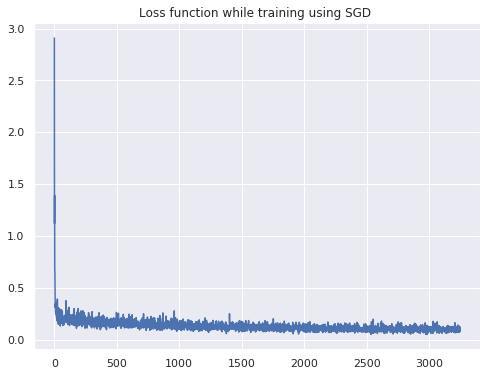

CPU times: user 5.64 s, sys: 445 ms, total: 6.08 s
Wall time: 5.97 s


In [ ]:
%%time

torch.manual_seed(0)

gc.collect()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
input_size = X_train.shape[1]
hidden_size = 100
num_classes = len(genres)
num_epochs = 50
batch_size = 20
learning_rate = 0.001

# Creating a custom dataset
my_dataset = utils.TensorDataset( torch.from_numpy(X_train)
                                 ,torch.from_numpy(Y_train) )

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=my_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
  
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = NeuralNet().float().to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam( model.parameters() , lr=learning_rate ) 


# for loss visualization 
general_loss = []

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
  
    for i, (inputs,labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        inputs = inputs.view(-1 ,input_size ).float().to(device)
        labels = labels.view(-1 , num_classes ).float().to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        
        loss = criterion(outputs, labels)
        general_loss.append ( loss )
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 50 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 

                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
            
            
            
            
            
plt.figure(figsize=(8,6))
plt.plot(general_loss)
plt.title("Loss function while training using SGD ")


plt.show()
      
  
  


### Test :

In [ ]:
Threshold = 0.2

soft_acc , hard_acc , hamming_score , all_pred , real_result = [] , [] , [] , [] , []

for i in range( X_test.shape[0] ) : 
 
  res = torch.sigmoid ( model( torch.from_numpy ( X_test[i] ).float().to(device)  ) )


  y_pred = (res > Threshold).cpu().numpy()
  y_true = Y_test[i]
  
  
  real_result.append ( res.detach().cpu().numpy() )  
  all_pred.append(y_pred)
  
  true_args = ( np.argwhere ( y_true == 1 ).flatten() )
  pred_args = ( np.argwhere ( y_pred == 1 ).flatten() )
  genres_predicted = [ dic_labs_mapping[k]  for k in dic_labs_mapping if k in pred_args ]
  #print("genre predicted example ",i," : ",genres_predicted)
  counts = np.array([1 for y in pred_args if y in true_args ]).sum()
  div = true_args.shape[0]
  
  soft_acc.append ( counts / div )
  hard_acc.append ( int( np.array_equal( true_args , pred_args ) ) )
  hamming_score.append( len( set(true_args).intersection(set(pred_args)) ) / len(set(true_args).union(set(pred_args))) )
  
  
soft_acc , hard_acc , hamming_score , all_pred , real_result    = \
np.array(soft_acc) ,  np.array (hard_acc) , np.array(hamming_score) , np.array (all_pred)  , np.array(real_result)

# soft accuracy : for each example   : count ( using ones in our sparse vectors )  predicted_classes / all_target_classes 



import warnings
warnings.filterwarnings('ignore')

rows = []
for lab in range( num_classes ) :
  
  y_true = Y_test[ : , lab ]
  y_pred = all_pred[ : , lab ]
  res =   real_result[: , lab ]
  rows . append ([ dic_labs_mapping[lab] ,
                 round ( precision_score(y_true,y_pred) , 2 ) ,
                 round ( recall_score(y_true,y_pred) , 2 )  ,
                 round ( f1_score(y_true,y_pred) , 2 )  ,
                 round ( average_precision_score(y_true,res) , 2 )
                 ])


  
rows = np.array(rows)

from IPython.display import display

print("On training data . . . \n")

metrics = pd.DataFrame(rows[ : , 1: ] , index=rows[:,0] , columns=[ 'Precision\
                     (K=27) ' , 'Recall (K=27) ' , 'F1-score (K=27) ' ,"AvgP" ])
display(metrics)


print("On Test data after Train,Test Split . . . \n")

stats = rows[:,1:5].astype(float)
means = np.mean( stats ,  axis=0 )
print("\n-----------------------")
print("metrics on labels : ")
print("-----------------------")
print("MAP : ",round ( means[3] , 2 ))
print ( "Precision macro : ",round ( means[0] , 2 ) ) 
print ( "Recall macro : ", round ( means[1] , 2 ) )
print ( "F1-score macro : ", round ( means[2] , 2 ) )
print("-----------------------")
print("metrics on samples : ")
print("-----------------------")
print('Hamming loss: ' , round(hamming_loss(Y_test, all_pred),2) )
print('Exact match ratio : ',round(hard_acc.mean(),2) )
print('Hamming score : ' , round(hamming_score.mean(),2) )
print('soft accuracy : ',round(soft_acc.mean(),2) )


On training data . . . 



,Precision (K=27),Recall (K=27),F1-score (K=27),AvgP
Alternative,0.36,0.45,0.4,0.35
Chanson française,0.0,0.0,0.0,0.08
Chill Out/Trip-Hop/Lounge,0.0,0.0,0.0,0.05
Classique,0.0,0.0,0.0,0.01
Dance,0.3,0.62,0.41,0.39
Electro,0.75,0.14,0.23,0.33
Films/Jeux vidéo,0.0,0.0,0.0,0.23
Latino,0.5,0.14,0.22,0.37
Metal,0.0,0.0,0.0,0.04
Musique africaine,0.0,0.0,0.0,0.03


On Test data after Train,Test Split . . . 


-----------------------
metrics on labels : 
-----------------------
MAP :  0.34
Precision macro :  0.44
Recall macro :  0.24
F1-score macro :  0.27
-----------------------
metrics on samples : 
-----------------------
Hamming loss:  0.06
Exact match ratio :  0.28
Hamming score :  0.43
soft accuracy :  0.53


**Confusion Matrix:**

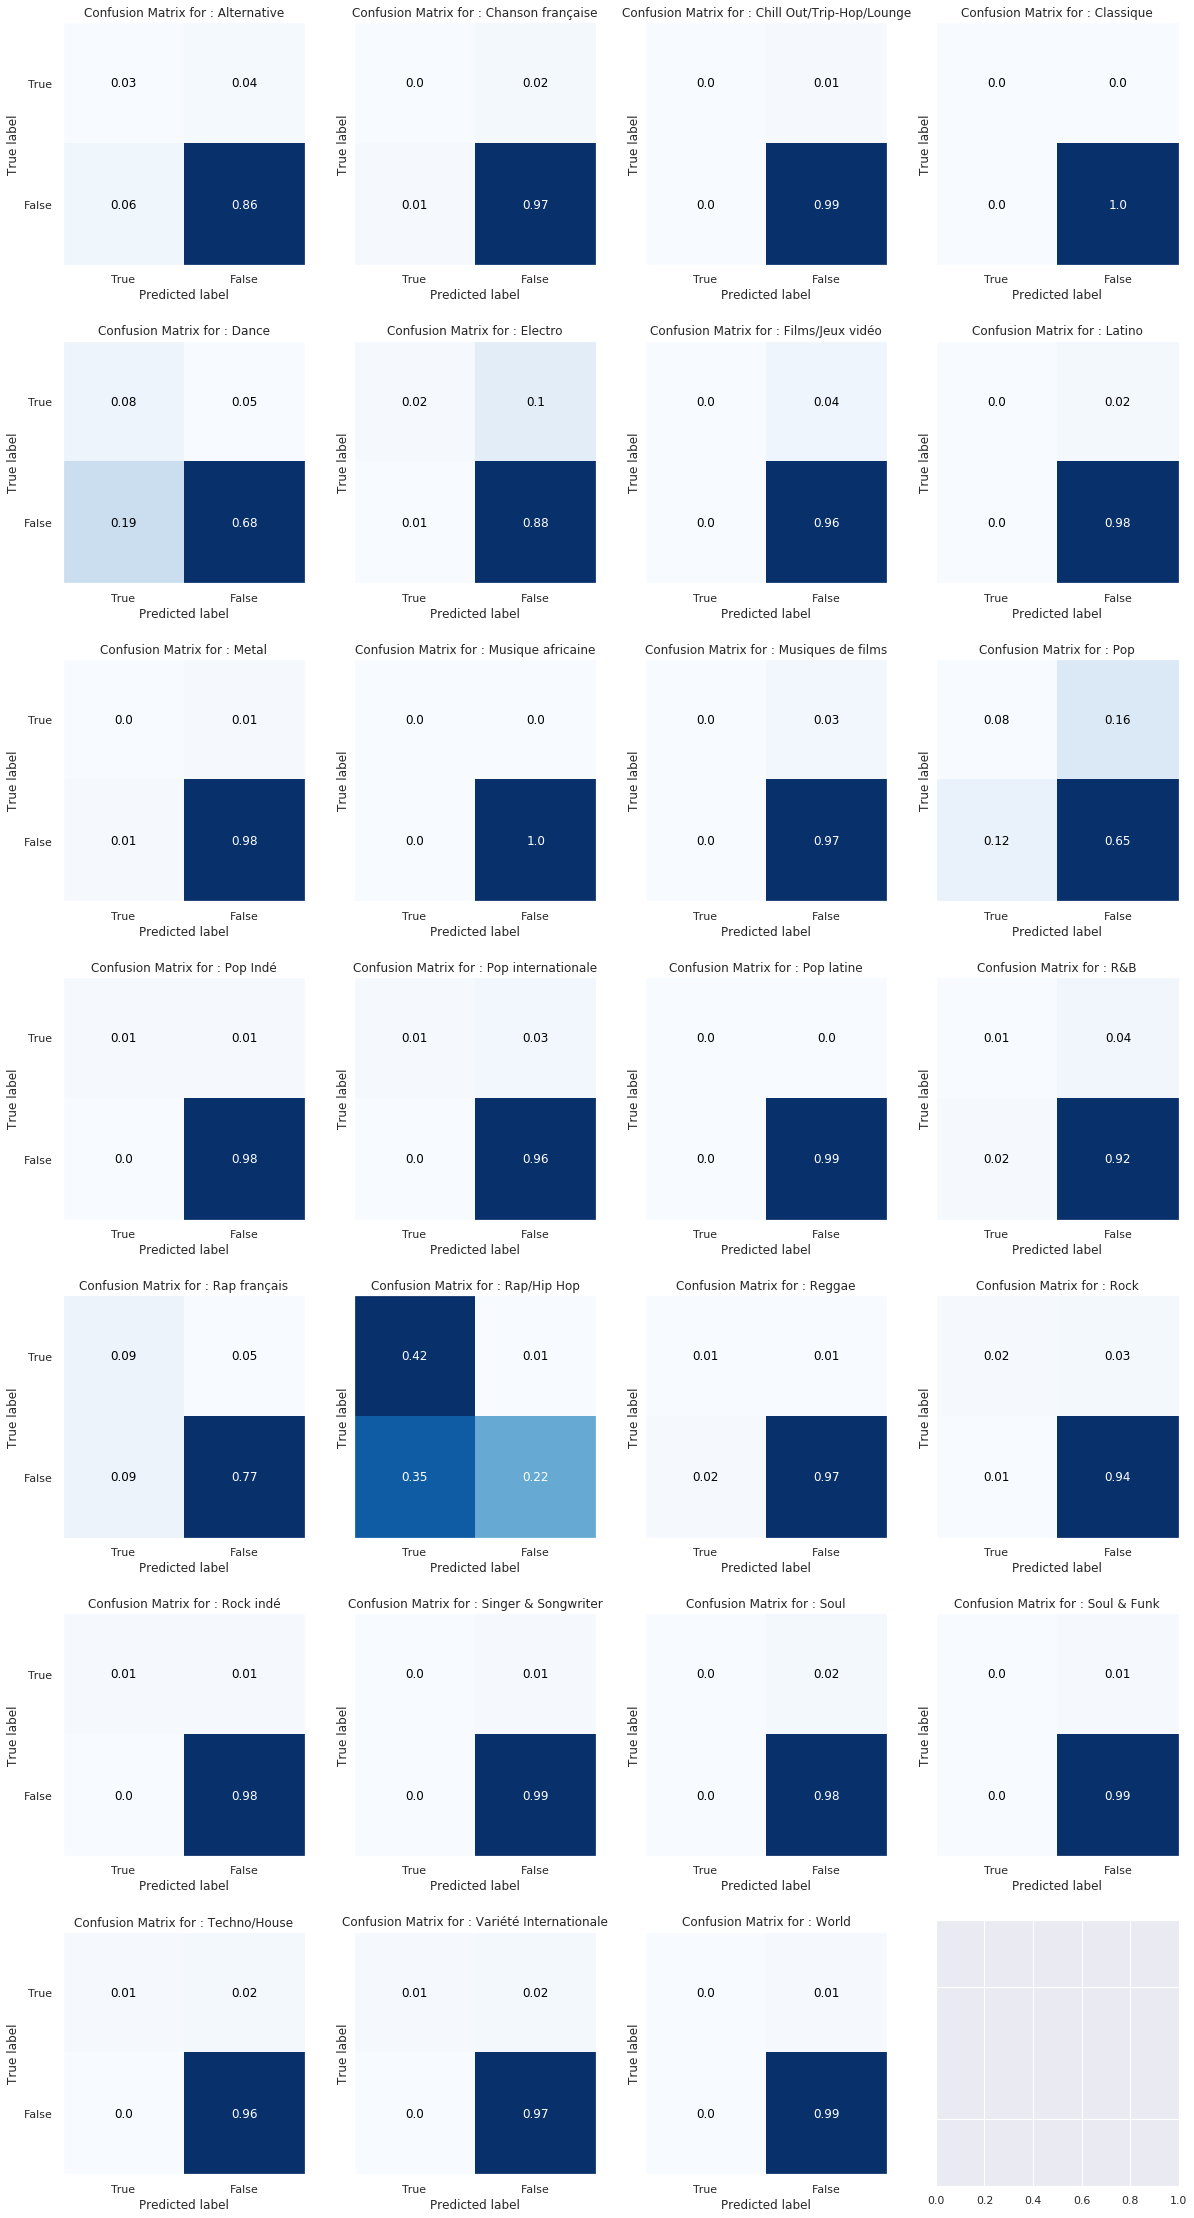

In [ ]:
cms = multilabel_confusion_matrix( Y_test , all_pred )



cmap=plt.cm.Blues

normalize = True 

fig, ax = plt.subplots(nrows=7 , ncols=4 , sharey=True )

fig.set_figwidth(20)
fig.set_figheight(40)


S = 0 
for i in range (7) : 
  for j in range (4) :
    if ( S < 27 ) : 
    
      # Rotations are for visualization because I used to see true positive as a first cell
      cm = np.rot90 ( np.rot90 ( cms[S] ) )
      if normalize:
        cm = cm.astype('float') / cm.sum()
        cm = np.around(cm, decimals=2)
        #pass
      
      thresh = cm.max() / 2.
      im = ax[i][j].imshow(cm, interpolation='nearest', cmap=cmap )
      ax[i][j].grid(False)
      # We want to show all ticks...
      ax[i][j].set(xticks=np.arange(cm.shape[1]),
             yticks=np.arange(cm.shape[0]),
             xticklabels=["True","False"], yticklabels=["True","False"],
             title="Confusion Matrix for : "+dic_labs_mapping[S] ,
             ylabel='True label',
             xlabel='Predicted label' )
      for id1 in range(1,-1,-1) : 
        for id2 in range(1,-1,-1) :
          ax[i][j].text(id2, id1, cm[id1 ,id2] ,
                    ha="center", va="center",
                    color="white" if cm[id1,id2] > thresh else "black")
      S += 1




## Unblanced Data

Sampler : 

In [ ]:
weights = torch.DoubleTensor(weights)                                       
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights)) 



## Steps = 3

In [ ]:
labels = df_multi_labels.values

# number of aggregated groups 
nbSteps=21
stepSize=np.ceil(maxSize/nbSteps)


# albums index array 
ialbums=[""]*len(albums.keys())   


data=np.zeros( ( len(albums.keys()) , nbSteps , len(villes.keys())  ) ,dtype="int16" )

    
gc.collect()

2351

In [ ]:
print("Albums ordered Confirmation ( Expected = 1537 ) <=> ( Found =",  ( np.array ( df_multi_labels.index ) == np.array( list(albums.keys()) ) ).sum(),")" )  


Albums ordered Confirmation ( Expected = 1537 ) <=> ( Found = 1537 )


In [ ]:
%%time

for a in albums :
  
  
  ialbums[albums[a]["id"]]=a
  
  steps=albums[a]["steps"]

  vals= np.zeros( ( nbSteps , len(villes.keys()) ) , dtype="int16" )

  for step in steps :  
    
    villes_dict =steps[step]
    
    group = int ( step // stepSize )

    for ville in villes_dict:
      
      vals[ group , ville ]+= villes_dict[ville]
      
      data[albums[a]["id"]]=vals
      
      
X_train , Y_train , X_test , Y_test = Custom_Train_Test_Split ( data , labels , training_percent = 0.8  )

CPU times: user 2.36 s, sys: 87.9 ms, total: 2.45 s
Wall time: 2.45 s


In [ ]:
X_train = X_train.reshape ( -1 , len(villes) * nbSteps )

X_test = X_test.reshape ( -1 , len(villes) * nbSteps )


Epoch [1/50], Step [50/65], Loss: 0.2956
Epoch [2/50], Step [50/65], Loss: 0.1662
Epoch [3/50], Step [50/65], Loss: 0.1187
Epoch [4/50], Step [50/65], Loss: 0.1377
Epoch [5/50], Step [50/65], Loss: 0.1498
Epoch [6/50], Step [50/65], Loss: 0.1370
Epoch [7/50], Step [50/65], Loss: 0.1266
Epoch [8/50], Step [50/65], Loss: 0.0981
Epoch [9/50], Step [50/65], Loss: 0.1005
Epoch [10/50], Step [50/65], Loss: 0.0911
Epoch [11/50], Step [50/65], Loss: 0.1137
Epoch [12/50], Step [50/65], Loss: 0.1006
Epoch [13/50], Step [50/65], Loss: 0.0620
Epoch [14/50], Step [50/65], Loss: 0.0872
Epoch [15/50], Step [50/65], Loss: 0.0919
Epoch [16/50], Step [50/65], Loss: 0.0840
Epoch [17/50], Step [50/65], Loss: 0.0885
Epoch [18/50], Step [50/65], Loss: 0.0751
Epoch [19/50], Step [50/65], Loss: 0.1073
Epoch [20/50], Step [50/65], Loss: 0.0613
Epoch [21/50], Step [50/65], Loss: 0.0635
Epoch [22/50], Step [50/65], Loss: 0.0610
Epoch [23/50], Step [50/65], Loss: 0.0643
Epoch [24/50], Step [50/65], Loss: 0.0326
E

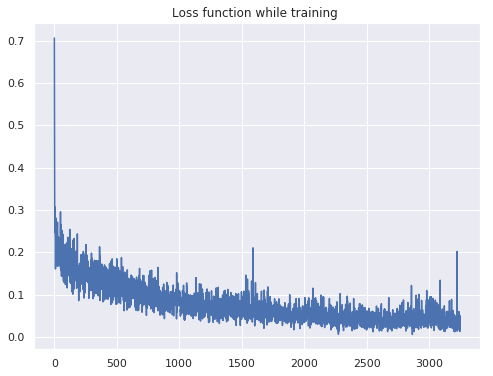

CPU times: user 16.3 s, sys: 2.03 s, total: 18.3 s
Wall time: 20.6 s


In [ ]:
%%time

torch.manual_seed(0)

gc.collect()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
input_size = X_train.shape[1]
hidden_size = 100
num_classes = len(genres)
num_epochs = 50
batch_size = 20
learning_rate = 0.001

# Creating a custom dataset
my_dataset = utils.TensorDataset( torch.from_numpy(X_train)
                                 ,torch.from_numpy(Y_train) )

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=my_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):
  
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = NeuralNet().float().to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate ) 


# for loss visualization 
general_loss = []

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
  
    for i, (inputs,labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        inputs = inputs.view(-1 ,input_size ).float().to(device)
        labels = labels.view(-1 , num_classes ).float().to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        
        loss = criterion(outputs, labels)
        general_loss.append ( loss )
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 50 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 

                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
            
            
            
            
            
plt.figure(figsize=(8,6))
plt.plot(general_loss)
plt.title("Loss function while training ")


plt.show()
      


In [ ]:

Threshold = 0.2

soft_acc , hard_acc , hamming_score , all_pred , real_result = [] , [] , [] , [] , []

for i in range( X_test.shape[0] ) : 
 
  res = torch.sigmoid ( model( torch.from_numpy ( X_test[i] ).float().to(device)  ) )


  y_pred = (res > Threshold).cpu().numpy()
  y_true = Y_test[i]
  
  
  real_result.append ( res.detach().cpu().numpy() )  
  all_pred.append(y_pred)
  
  true_args = ( np.argwhere ( y_true == 1 ).flatten() )
  pred_args = ( np.argwhere ( y_pred == 1 ).flatten() )
  genres_predicted = [ dic_labs_mapping[k]  for k in dic_labs_mapping if k in pred_args ]
  #print("genre predicted example ",i," : ",genres_predicted)
  counts = np.array([1 for y in pred_args if y in true_args ]).sum()
  div = true_args.shape[0]
  
  soft_acc.append ( counts / div )
  hard_acc.append ( int( np.array_equal( true_args , pred_args ) ) )
  hamming_score.append( len( set(true_args).intersection(set(pred_args)) ) / len(set(true_args).union(set(pred_args))) )
  
  
soft_acc , hard_acc , hamming_score , all_pred , real_result    = \
np.array(soft_acc) ,  np.array (hard_acc) , np.array(hamming_score) , np.array (all_pred)  , np.array(real_result)

# soft accuracy : for each example   : count ( using ones in our sparse vectors )  predicted_classes / all_target_classes 



import warnings
warnings.filterwarnings('ignore')

rows = []
for lab in range( num_classes ) :
  
  y_true = Y_test[ : , lab ]
  y_pred = all_pred[ : , lab ]
  res =   real_result[: , lab ]
  
  rows . append ([ dic_labs_mapping[lab] ,
                 precision_score(y_true,y_pred) ,
                 recall_score(y_true,y_pred) ,
                 f1_score(y_true,y_pred) ,
                 average_precision_score(y_true,res)
                 ])
  
  
rows = np.array(rows)

print("On Test data after Train,Test Split . . . \n")

stats = rows[:,1:5].astype(float)
means = np.mean( stats ,  axis=0 )
print ( tabulate( rows , headers=[ 'Classe', 'Precision (K=27) ' , 'Recall (K=27) ' , 'F1-score (K=27) ' ,"AvgP" ]  ) )
print("\n-----------------------")
print("metrics on labels : ")
print("-----------------------")
print("MAP : ",round ( means[3] , 2 ))
print ( "Precision mean : ",round ( means[0] , 2 ) ) 
print ( "Recall mean : ", round ( means[1] , 2 ) )
print ( "F1-score mean : ", round ( means[2] , 2 ) )
print("-----------------------")
print("metrics on samples : ")
print("-----------------------")
print('Hamming loss: ' , round(hamming_loss(Y_test, all_pred),2) )
print('Exact match ratio : ',round(hard_acc.mean(),2) )
print('Hamming score : ' , round(hamming_score.mean(),2) )
print('soft accuracy : ',round(soft_acc.mean(),2) )


On Test data after Train,Test Split . . . 

Classe                       Precision (K=27)     Recall (K=27)     F1-score (K=27)        AvgP
-------------------------  -------------------  ----------------  ------------------  ---------
Alternative                           0.378378          0.482759            0.424242  0.364163
Chanson française                     0.142857          0.125               0.133333  0.0783457
Chill Out/Trip-Hop/Lounge             0                 0                   0         0.291667
Classique                             0                 0                   0         0.0333333
Dance                                 0.55102           0.54                0.545455  0.591759
Electro                               0.5               0.522727            0.511111  0.526525
Films/Jeux vidéo                      0.846154          0.785714            0.814815  0.693932
Latino                                1                 0.571429            0.727273  0.594482
Me

**Confusion Matrix:**

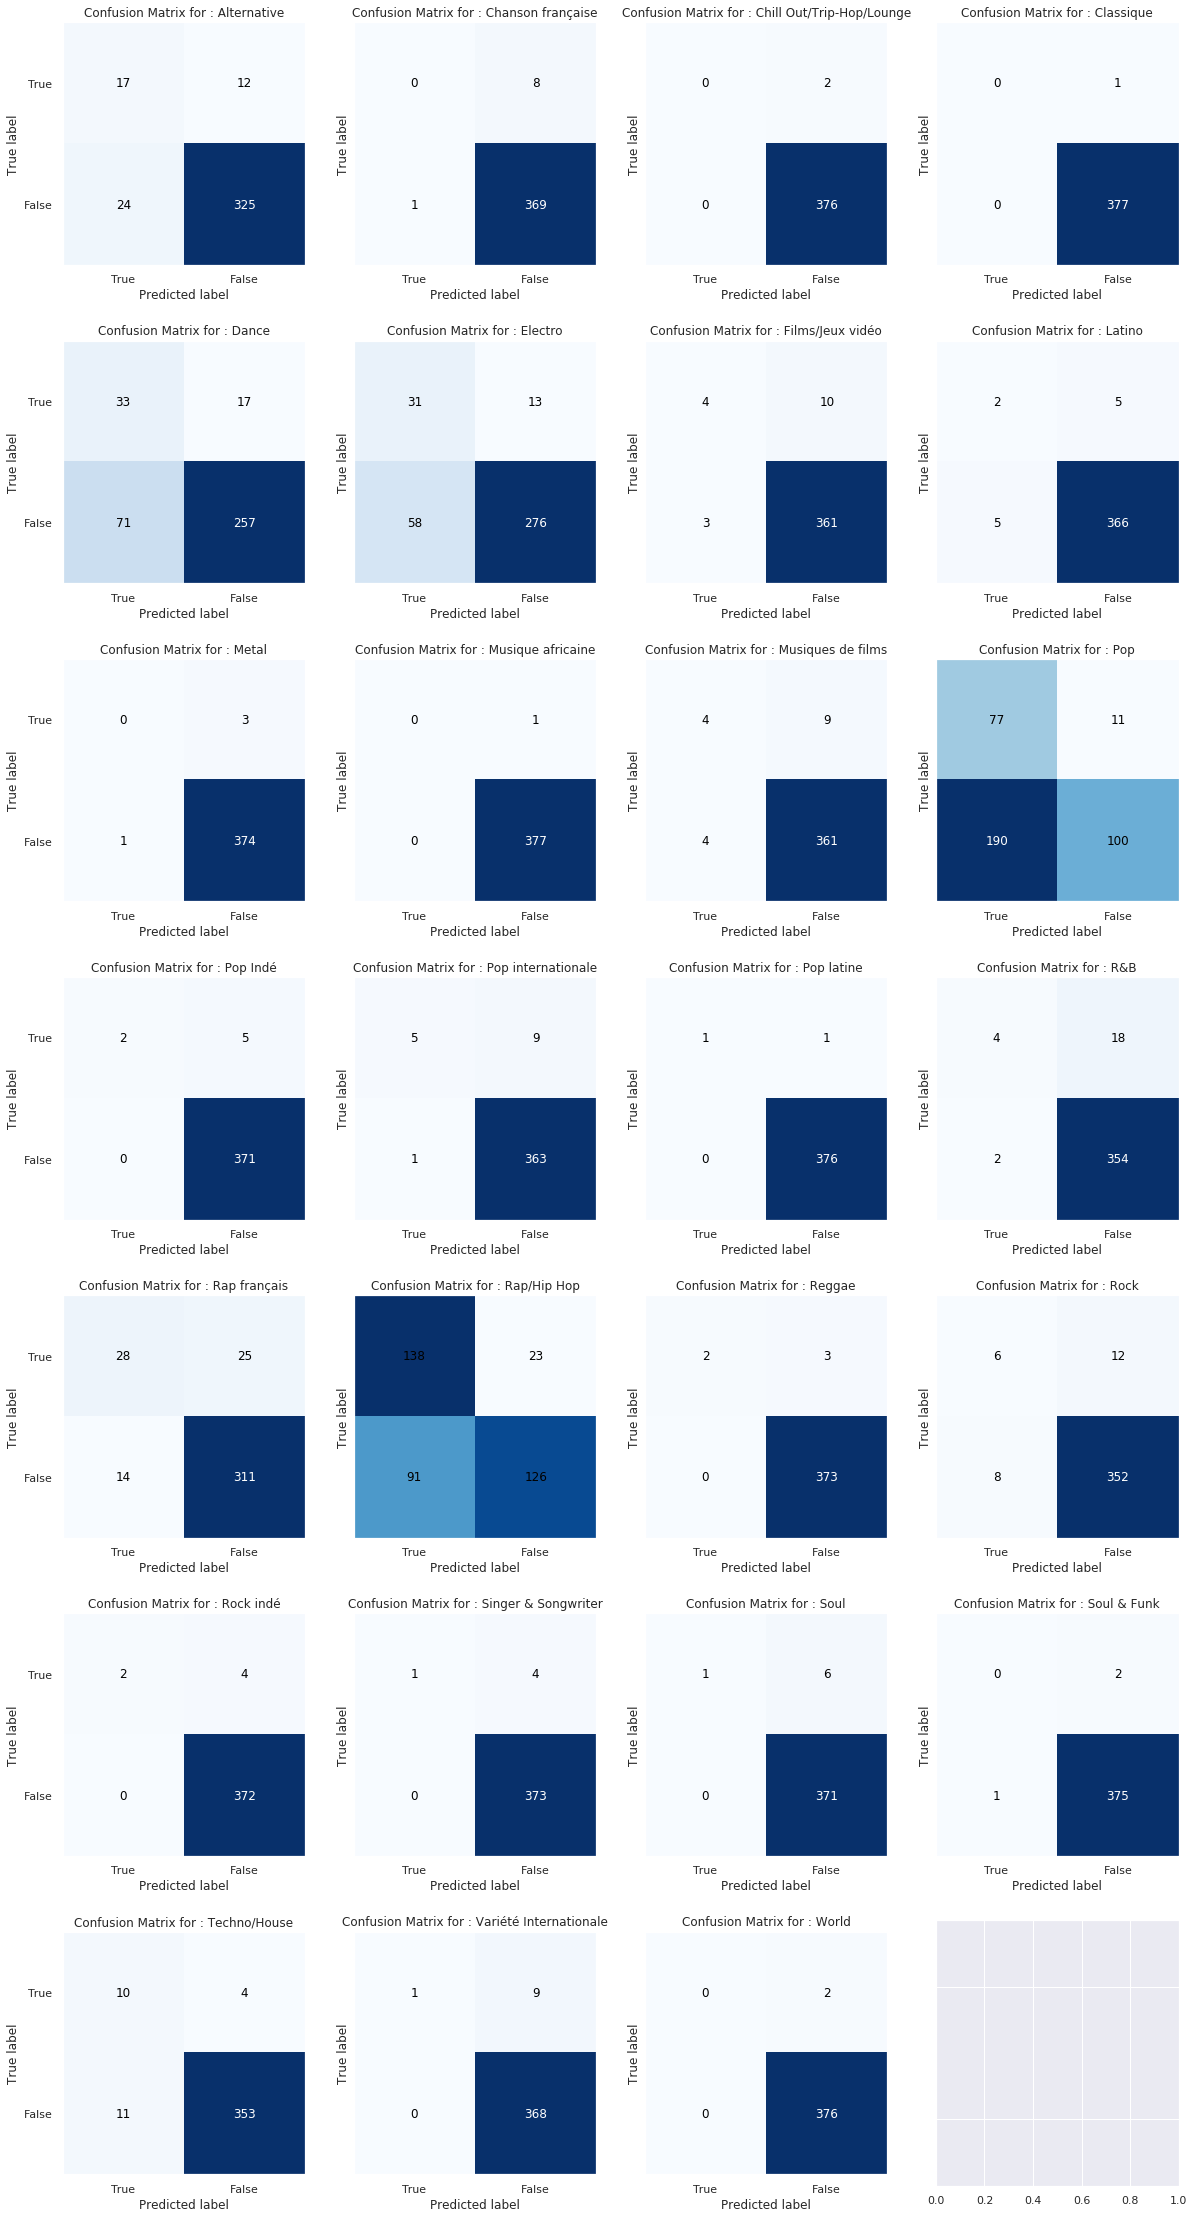

In [ ]:
cms = multilabel_confusion_matrix( Y_test , all_pred )



cmap=plt.cm.Blues


fig, ax = plt.subplots(nrows=7 , ncols=4 , sharey=True )

fig.set_figwidth(20)
fig.set_figheight(40)
thresh = cms.max() / 2

S = 0 
for i in range (7) : 
  for j in range (4) :
    if ( S < 27 ) : 
    
      # Rotations are for visualization because I used to see true positive as a first cell
      cm = np.rot90 ( np.rot90 ( cms[S] ) )
      
      im = ax[i][j].imshow(cm, interpolation='nearest', cmap=cmap )
      ax[i][j].grid(False)
      # We want to show all ticks...
      ax[i][j].set(xticks=np.arange(cm.shape[1]),
             yticks=np.arange(cm.shape[0]),
             xticklabels=["True","False"], yticklabels=["True","False"],
             title="Confusion Matrix for : "+dic_labs_mapping[S] ,
             ylabel='True label',
             xlabel='Predicted label' )
      for id1 in range(1,-1,-1) : 
        for id2 in range(1,-1,-1) :
          ax[i][j].text(id2, id1, cm[id1 ,id2] ,
                    ha="center", va="center",
                    color="white" if cm[id1,id2] > thresh else "black")
      S += 1




## Varying Steps from 1 to 30  :

In [ ]:
%%time

MAPs , LabelsMetrics , SamplesMetrics  = list() , list() , list()


for nbSteps in np.arange (1,31) :
  
    # number of aggregated groups 
    print("step = ",nbSteps)
    stepSize=np.ceil(maxSize/nbSteps)


    # albums index array 
    ialbums=[""]*len(albums.keys())   


    data=np.zeros( ( len(albums.keys()) , nbSteps , len(villes.keys())  ) ,dtype="int16" )


    gc.collect()


    for a in albums :


      ialbums[albums[a]["id"]]=a

      steps=albums[a]["steps"]

      vals= np.zeros( ( nbSteps , len(villes.keys()) ) , dtype="int16" )

      for step in steps :  

        villes_dict =steps[step]

        group = int ( step // stepSize )

        for ville in villes_dict:

          vals[ group , ville ]+= villes_dict[ville]

          data[albums[a]["id"]]=vals




    gc.collect()
    
    
    # data matrix , split train , test 
    labels = df_multi_labels.values
    X_train , Y_train , X_test , Y_test = Custom_Train_Test_Split ( data , labels , training_percent = 0.8  )
    X_train = X_train.reshape ( -1 , len(villes) * nbSteps )
    X_test = X_test.reshape ( -1 , len(villes) * nbSteps )

    print( X_train.shape )
    
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Hyper-parameters 
    input_size = X_train.shape[1] 
    hidden_size = 100 * nbSteps
    num_classes = len(genres)
    num_epochs = 50
    batch_size = 16
    learning_rate = 0.001

    # Creating a custom dataset
    my_dataset = utils.TensorDataset( torch.from_numpy(X_train)
                                     ,torch.from_numpy(Y_train) )

    # Data loader
    train_loader = torch.utils.data.DataLoader(dataset=my_dataset, 
                                               batch_size=batch_size, 
                                               shuffle=True)

    # Fully connected neural network with one hidden layer
    class NeuralNet(nn.Module):

        def __init__(self):
            super(NeuralNet, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size) 
            self.fc2 = nn.Linear(hidden_size, num_classes)  

        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = self.fc2(x)
            return x


    model = NeuralNet().float().to(device)

    # Loss and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam( model.parameters() , lr=learning_rate ) 


    # for loss visualization 
    general_loss = []

    # Train the model
    total_step = len(train_loader)
    for epoch in range(num_epochs):

        for i, (inputs,labels) in enumerate(train_loader):  
            # Move tensors to the configured device
            inputs = inputs.view(-1 ,input_size ).float().to(device)
            labels = labels.view(-1 , num_classes ).float().to(device)

            # Forward pass
            outputs = model(inputs)


            loss = criterion(outputs, labels)
            general_loss.append ( loss )

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        
    
    Threshold = 0.2

    soft_acc , hard_acc , hamming_score , all_pred , real_result = [] , [] , [] , [] , []

    for i in range( X_test.shape[0] ) : 

      res = torch.sigmoid ( model( torch.from_numpy ( X_test[i] ).float().to(device)  ) )


      y_pred = (res > Threshold).cpu().numpy()
      y_true = Y_test[i]


      real_result.append ( res.detach().cpu().numpy() )  
      all_pred.append(y_pred)

      true_args = ( np.argwhere ( y_true == 1 ).flatten() )
      pred_args = ( np.argwhere ( y_pred == 1 ).flatten() )
      
      if ( pred_args.shape[0] == 0 ):
        
        pred_args = np.array ( [torch.max(res, 0)[1].cpu().item()] )
      
      genres_predicted = [ dic_labs_mapping[k]  for k in dic_labs_mapping if k in pred_args ]
      #print("genre predicted example ",i," : ",genres_predicted)
      counts = np.array([1 for y in pred_args if y in true_args ]).sum()
      div = true_args.shape[0]

      soft_acc.append ( counts / div )
      hard_acc.append ( int( np.array_equal( true_args , pred_args ) ) )
      hamming_score.append( len( set(true_args).intersection(set(pred_args)) ) / len(set(true_args).union(set(pred_args))) )


    soft_acc , hard_acc , hamming_score , all_pred , real_result    = \
    np.array(soft_acc) ,  np.array (hard_acc) , np.array(hamming_score) , np.array (all_pred)  , np.array(real_result)

    # soft accuracy : for each example   : count ( using ones in our sparse vectors )  predicted_classes / all_target_classes 



    import warnings
    warnings.filterwarnings('ignore')

    rows = []
    for lab in range( num_classes ) :

      y_true = Y_test[ : , lab ]
      y_pred = all_pred[ : , lab ]
      res =   real_result[: , lab ]

      rows . append ([ dic_labs_mapping[lab] ,
                     precision_score(y_true,y_pred) ,
                     recall_score(y_true,y_pred) ,
                     f1_score(y_true,y_pred) ,
                     average_precision_score(y_true,res)
                     ])


    rows = np.array(rows)

    print("On Test data after Train,Test Split . . . \n")

    stats = rows[:,1:5].astype(float)
    means = np.mean( stats ,  axis=0 )
    
    
    MAPs.append ( round ( means[3] , 2 ) )
    LabelsMetrics.append ( [ round ( means[0] , 2 ) , round ( means[1] , 2 ) ,
                             round ( means[2] , 2 ) ] )
    SamplesMetrics.append ( [ 
                               round(hard_acc.mean(),2) ,
                               round(hamming_score.mean(),2),
                               round(soft_acc.mean(),2)
                             ] )


    


In [ ]:
MAPs , SamplesMetrics , LabelsMetrics  = np.array(MAPs) , np.array(SamplesMetrics) , np.array(LabelsMetrics)   

MAP :

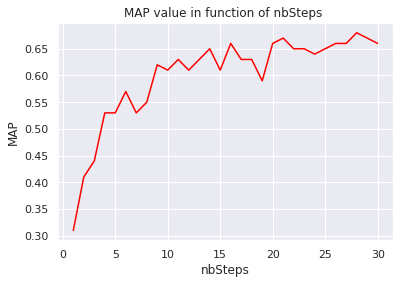

In [ ]:
plt.plot ( np.arange(1,31) , MAPs , 'red' )
plt.title ( "MAP value in function of nbSteps " )
plt.xlabel("nbSteps")
plt.ylabel("MAP")

plt.show()

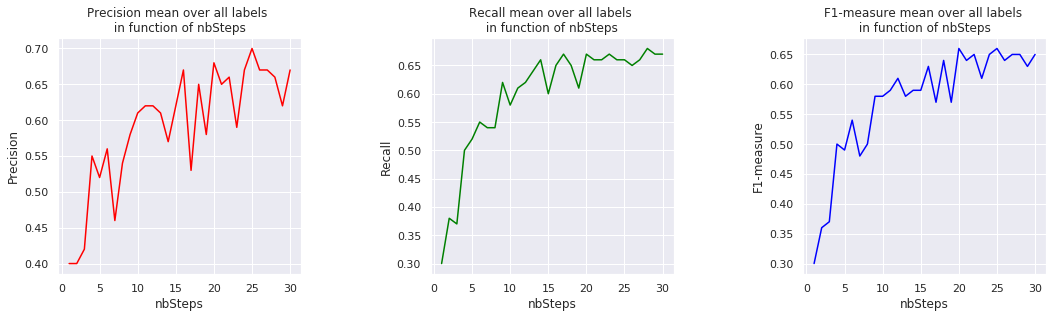

In [ ]:
fig , ax = plt.subplots( nrows=1 , ncols=3 )
headers = ["Precision","Recall","F1-measure"]
colors = ['red','green','blue']
plt.tight_layout()
fig.set_figwidth(16)


for i in range(3) : 
  
  ax[i].plot ( np.arange(1,31) , LabelsMetrics[:,i] , colors[i] )
  ax[i].set_title (headers[i]+" mean over all labels \n in function of nbSteps " )
  ax[i].set_xlabel("nbSteps")
  ax[i].set_ylabel(headers[i])

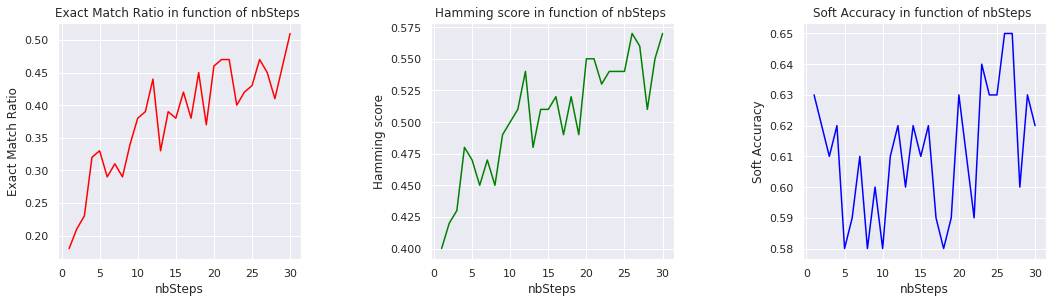

In [ ]:
fig , ax = plt.subplots( nrows=1 , ncols=3 )
headers = ["Exact Match Ratio","Hamming score","Soft Accuracy"]
colors = ['red','green','blue']
plt.tight_layout()
fig.set_figwidth(16)


for i in range(3) : 
  
  ax[i].plot ( np.arange(1,31) , SamplesMetrics[:,i] , colors[i] )
  ax[i].set_title (headers[i]+" in function of nbSteps " )
  ax[i].set_xlabel("nbSteps")
  ax[i].set_ylabel(headers[i])

In [ ]:
print ("best nbSteps for all metrics : ")
print( "MAP : best_nbSteps = ", MAPs.argmax()+1 , " value = " ,
        MAPs[ MAPs.argmax()]  )
print("-----------------------------------------------")
print ( "Precision,Recall,F1 : best_nbSteps = ",(LabelsMetrics.argmax(axis=0))+1,
        "values = \n", LabelsMetrics [ LabelsMetrics.argmax(axis=0) , : ].max(axis=0) )
print("-----------------------------------------------")
print ( "Exact Match , Hamming score , soft accuracy : best_nbSteps = ",(SamplesMetrics.argmax(axis=0))+1,
        "values = \n", SamplesMetrics [ SamplesMetrics.argmax(axis=0) , : ].max(axis=0) )




best nbSteps for all metrics : 
MAP : best_nbSteps =  28  value =  0.68
-----------------------------------------------
Precision,Recall,F1 : best_nbSteps =  [25 28 20] values = 
 [0.7  0.68 0.66]
-----------------------------------------------
Exact Match , Hamming score , soft accuracy : best_nbSteps =  [30 26 26] values = 
 [0.51 0.57 0.65]


### best nb_steps = 28 :

In [ ]:
%%time


nbSteps = 28 

# number of aggregated groups 
print("step = ",nbSteps)
stepSize=np.ceil(maxSize/nbSteps)


# albums index array 
ialbums=[""]*len(albums.keys())   


data=np.zeros( ( len(albums.keys()) , nbSteps , len(villes.keys())  ) ,dtype="int16" )


gc.collect()


for a in albums :


  ialbums[albums[a]["id"]]=a

  steps=albums[a]["steps"]

  vals= np.zeros( ( nbSteps , len(villes.keys()) ) , dtype="int16" )

  for step in steps :  

    villes_dict =steps[step]

    group = int ( step // stepSize )

    for ville in villes_dict:

      vals[ group , ville ]+= villes_dict[ville]

      data[albums[a]["id"]]=vals




gc.collect()


# data matrix , split train , test 
labels = df_multi_labels.values
X_train , Y_train , X_test , Y_test = Custom_Train_Test_Split ( data , labels , training_percent = 0.8  )
X_train = X_train.reshape ( -1 , len(villes) * nbSteps )
X_test = X_test.reshape ( -1 , len(villes) * nbSteps )

print( X_train.shape )

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
input_size = X_train.shape[1] 
hidden_size = 100 * nbSteps
num_classes = len(genres)
num_epochs = 50
batch_size = 16
learning_rate = 0.001

# Creating a custom dataset
my_dataset = utils.TensorDataset( torch.from_numpy(X_train)
                                 ,torch.from_numpy(Y_train) )

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=my_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

# Fully connected neural network with one hidden layer
class NeuralNet(nn.Module):

    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)  

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = NeuralNet().float().to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam( model.parameters() , lr=learning_rate ) 


# for loss visualization 
general_loss = []

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):

    for i, (inputs,labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        inputs = inputs.view(-1 ,input_size ).float().to(device)
        labels = labels.view(-1 , num_classes ).float().to(device)

        # Forward pass
        outputs = model(inputs)


        loss = criterion(outputs, labels)
        general_loss.append ( loss )

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    


step =  28
(1292, 75124)
CPU times: user 3min 23s, sys: 2min 35s, total: 5min 58s
Wall time: 6min


In [ ]:
%%time

MAPs , LabelsMetrics , SamplesMetrics  = list() , list() , list()

for th in np.arange (0.05 , 0.8 , 0.05) :

    Threshold = th

    soft_acc , hard_acc , hamming_score , all_pred , real_result = [] , [] , [] , [] , []

    for i in range( X_test.shape[0] ) : 

      res = torch.sigmoid ( model( torch.from_numpy ( X_test[i] ).float().to(device)  ) )


      y_pred = (res > Threshold).cpu().numpy()
      y_true = Y_test[i]


      real_result.append ( res.detach().cpu().numpy() )  
      all_pred.append(y_pred)

      true_args = ( np.argwhere ( y_true == 1 ).flatten() )
      pred_args = ( np.argwhere ( y_pred == 1 ).flatten() )
      
      if ( pred_args.shape[0] == 0 ):
        
        pred_args = np.array ( [torch.max(res, 0)[1].cpu().item()] )
      
      genres_predicted = [ dic_labs_mapping[k]  for k in dic_labs_mapping if k in pred_args ]
      #print("genre predicted example ",i," : ",genres_predicted)
      counts = np.array([1 for y in pred_args if y in true_args ]).sum()
      div = true_args.shape[0]

      soft_acc.append ( counts / div )
      hard_acc.append ( int( np.array_equal( true_args , pred_args ) ) )
      hamming_score.append( len( set(true_args).intersection(set(pred_args)) ) / len(set(true_args).union(set(pred_args))) )


    soft_acc , hard_acc , hamming_score , all_pred , real_result    = \
    np.array(soft_acc) ,  np.array (hard_acc) , np.array(hamming_score) , np.array (all_pred)  , np.array(real_result)

    # soft accuracy : for each example   : count ( using ones in our sparse vectors )  predicted_classes / all_target_classes 



    import warnings
    warnings.filterwarnings('ignore')

    rows = []
    for lab in range( num_classes ) :

      y_true = Y_test[ : , lab ]
      y_pred = all_pred[ : , lab ]
      res =   real_result[: , lab ]

      rows . append ([ dic_labs_mapping[lab] ,
                     precision_score(y_true,y_pred) ,
                     recall_score(y_true,y_pred) ,
                     f1_score(y_true,y_pred) ,
                     average_precision_score(y_true,res)
                     ])


    rows = np.array(rows)


    stats = rows[:,1:5].astype(float)
    means = np.mean( stats ,  axis=0 )

    print(th)
    MAPs.append ( round ( means[3] , 2 ) )
    LabelsMetrics.append ( [ round ( means[0] , 2 ) , round ( means[1] , 2 ) ,
                             round ( means[2] , 2 ) ] )
    SamplesMetrics.append ( [ 
                               round(hard_acc.mean(),2) ,
                               round(hamming_score.mean(),2),
                               round(soft_acc.mean(),2)
                             ] )


    

0.05
0.1
0.15000000000000002
0.2
0.25
0.3
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.6500000000000001
0.7000000000000001
0.7500000000000001
CPU times: user 15 s, sys: 8.83 s, total: 23.8 s
Wall time: 23.9 s


In [ ]:
MAPs , SamplesMetrics , LabelsMetrics  = np.array(MAPs) , np.array(SamplesMetrics) , np.array(LabelsMetrics)   


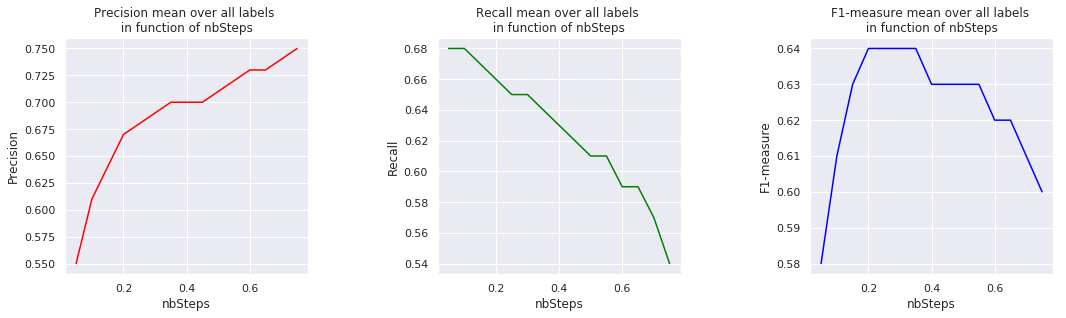

In [ ]:
fig , ax = plt.subplots( nrows=1 , ncols=3 )
headers = ["Precision","Recall","F1-measure"]
colors = ['red','green','blue']
plt.tight_layout()
fig.set_figwidth(16)


for i in range(3) : 
  
  ax[i].plot ( np.arange (0.05 , 0.8 , 0.05)  , LabelsMetrics[:,i] , colors[i] )
  ax[i].set_title (headers[i]+" mean over all labels \n in function of nbSteps " )
  ax[i].set_xlabel("nbSteps")
  ax[i].set_ylabel(headers[i])

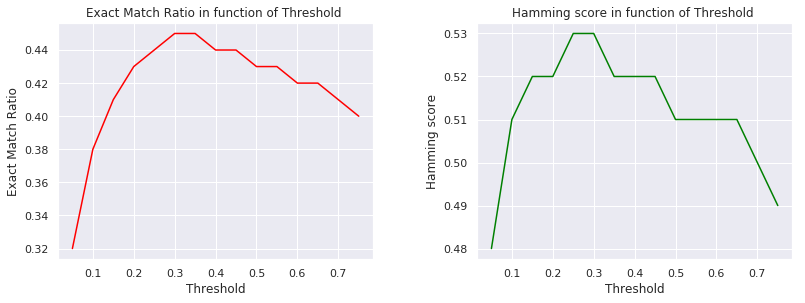

In [ ]:
fig , ax = plt.subplots( nrows=1 , ncols=2 )
headers = ["Exact Match Ratio","Hamming score"]
colors = ['red','green']
plt.tight_layout()
fig.set_figwidth(12)


for i in range(2) : 
  
  ax[i].plot ( np.arange (0.05 , 0.8 , 0.05)  , SamplesMetrics[:,i] , colors[i] )
  ax[i].set_title (headers[i]+" in function of Threshold " )
  ax[i].set_xlabel("Threshold")
  ax[i].set_ylabel(headers[i])



```
# This is formatted as code
```

**Best Threshold == 0.3  and Best nbSteps=28**

In [ ]:

Threshold = 0.3

soft_acc , hard_acc , hamming_score , all_pred , real_result = [] , [] , [] , [] , []

for i in range( X_test.shape[0] ) : 
 
  res = torch.sigmoid ( model( torch.from_numpy ( X_test[i] ).float().to(device)  ) )


  y_pred = (res > Threshold).cpu().numpy()
  y_true = Y_test[i]
  
  
  real_result.append ( res.detach().cpu().numpy() )  
  all_pred.append(y_pred)
  
  true_args = ( np.argwhere ( y_true == 1 ).flatten() )
  pred_args = ( np.argwhere ( y_pred == 1 ).flatten() )
  genres_predicted = [ dic_labs_mapping[k]  for k in dic_labs_mapping if k in pred_args ]
  #print("genre predicted example ",i," : ",genres_predicted)
  counts = np.array([1 for y in pred_args if y in true_args ]).sum()
  div = true_args.shape[0]
  
  soft_acc.append ( counts / div )
  hard_acc.append ( int( np.array_equal( true_args , pred_args ) ) )
  hamming_score.append( len( set(true_args).intersection(set(pred_args)) ) / len(set(true_args).union(set(pred_args))) )
  
  
soft_acc , hard_acc , hamming_score , all_pred , real_result    = \
np.array(soft_acc) ,  np.array (hard_acc) , np.array(hamming_score) , np.array (all_pred)  , np.array(real_result)

# soft accuracy : for each example   : count ( using ones in our sparse vectors )  predicted_classes / all_target_classes 


import warnings
warnings.filterwarnings('ignore')

rows = []
for lab in range( num_classes ) :
  
  y_true = Y_test[ : , lab ]
  y_pred = all_pred[ : , lab ]
  res =   real_result[: , lab ]
  rows . append ([ dic_labs_mapping[lab] ,
                 round ( precision_score(y_true,y_pred) , 2 ) ,
                 round ( recall_score(y_true,y_pred) , 2 )  ,
                 round ( f1_score(y_true,y_pred) , 2 )  ,
                 round ( average_precision_score(y_true,res) , 2 )
                 ])


  
rows = np.array(rows)

from IPython.display import display


metrics = pd.DataFrame(rows[ : , 1: ] , index=rows[:,0] , columns=[ 'Precision\
                     (K=27) ' , 'Recall (K=27) ' , 'F1-score (K=27) ' ,"AvgP" ])
display(metrics)


print("On Test data after Train,Test Split . . . \n")

stats = rows[:,1:5].astype(float)
means = np.mean( stats ,  axis=0 )
print("\n-----------------------")
print("metrics on labels : ")
print("-----------------------")
print("MAP : ",round ( means[3] , 2 ))
print ( "Precision macro : ",round ( means[0] , 2 ) ) 
print ( "Recall macro : ", round ( means[1] , 2 ) )
print ( "F1-score macro : ", round ( means[2] , 2 ) )
print("-----------------------")
print("metrics on samples : ")
print("-----------------------")
print('Hamming loss: ' , round(hamming_loss(Y_test, all_pred),2) )
print('Exact match ratio : ',round(hard_acc.mean(),2) )
print('Hamming score : ' , round(hamming_score.mean(),2) )
print('soft accuracy : ',round(soft_acc.mean(),2) )


,Precision (K=27),Recall (K=27),F1-score (K=27),AvgP
Alternative,0.5,0.52,0.51,0.52
Chanson française,0.33,0.12,0.18,0.16
Chill Out/Trip-Hop/Lounge,1.0,1.0,1.0,1.0
Classique,0.0,0.0,0.0,0.01
Dance,0.54,0.58,0.56,0.58
Electro,0.5,0.66,0.57,0.68
Films/Jeux vidéo,0.92,0.86,0.89,0.87
Latino,0.67,0.57,0.62,0.62
Metal,1.0,0.67,0.8,0.92
Musique africaine,0.0,0.0,0.0,0.01


On Test data after Train,Test Split . . . 


-----------------------
metrics on labels : 
-----------------------
MAP :  0.68
Precision macro :  0.72
Recall macro :  0.66
F1-score macro :  0.68
-----------------------
metrics on samples : 
-----------------------
Hamming loss:  0.03
Exact match ratio :  0.47
Hamming score :  0.53
soft accuracy :  0.59


In [ ]:
MAPs , SamplesMetrics , LabelsMetrics  = np.array(MAPs) , np.array(SamplesMetrics) , np.array(LabelsMetrics)   

MAP :

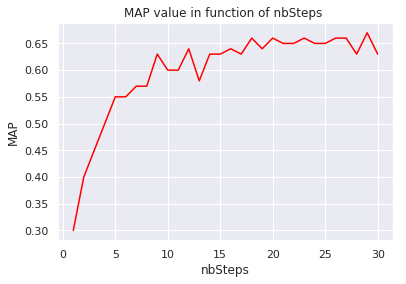

In [ ]:
plt.plot ( np.arange(1,31) , MAPs , 'red' )
plt.title ( "MAP value in function of nbSteps " )
plt.xlabel("nbSteps")
plt.ylabel("MAP")

plt.show()

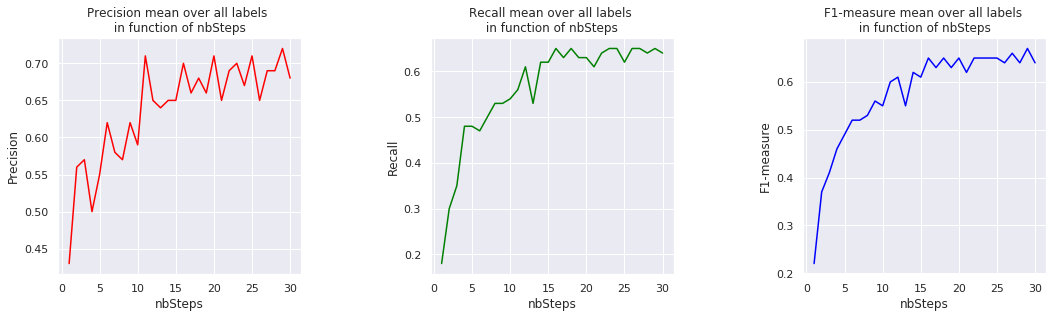

In [ ]:
fig , ax = plt.subplots( nrows=1 , ncols=3 )
headers = ["Precision","Recall","F1-measure"]
colors = ['red','green','blue']
plt.tight_layout()
fig.set_figwidth(16)


for i in range(3) : 
  
  ax[i].plot ( np.arange(1,31) , LabelsMetrics[:,i] , colors[i] )
  ax[i].set_title (headers[i]+" mean over all labels \n in function of nbSteps " )
  ax[i].set_xlabel("nbSteps")
  ax[i].set_ylabel(headers[i])

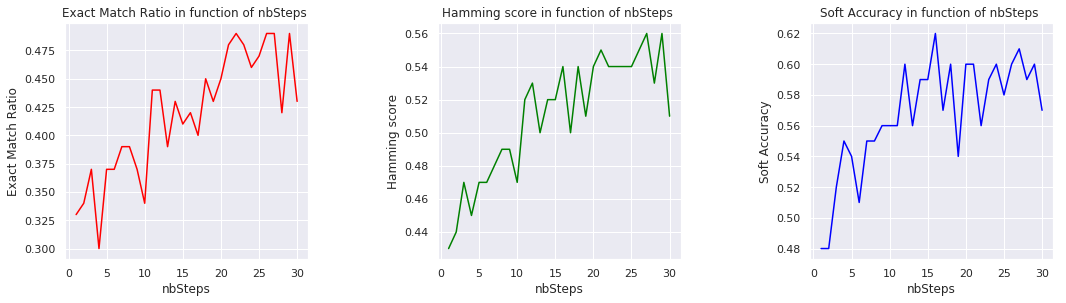

In [ ]:
fig , ax = plt.subplots( nrows=1 , ncols=3 )
headers = ["Exact Match Ratio","Hamming score","Soft Accuracy"]
colors = ['red','green','blue']
plt.tight_layout()
fig.set_figwidth(16)


for i in range(3) : 
  
  ax[i].plot ( np.arange(1,31) , SamplesMetrics[:,i] , colors[i] )
  ax[i].set_title (headers[i]+" in function of nbSteps " )
  ax[i].set_xlabel("nbSteps")
  ax[i].set_ylabel(headers[i])

In [ ]:
print ("best nbSteps for all metrics : ")
print( "MAP : best_nbSteps = ", MAPs.argmax()+1 , " value = " ,
        MAPs[ MAPs.argmax()]  )
print("-----------------------------------------------")
print ( "Precision,Recall,F1 : best_nbSteps = ",(LabelsMetrics.argmax(axis=0))+1,
        "values = \n", LabelsMetrics [ LabelsMetrics.argmax(axis=0) , : ].max(axis=0) )
print("-----------------------------------------------")
print ( "Exact Match , Hamming score , soft accuracy : best_nbSteps = ",(SamplesMetrics.argmax(axis=0))+1,
        "values = \n", SamplesMetrics [ SamplesMetrics.argmax(axis=0) , : ].max(axis=0) )




best nbSteps for all metrics : 
MAP : best_nbSteps =  28  value =  0.68
-----------------------------------------------
Precision,Recall,F1 : best_nbSteps =  [25 28 20] values = 
 [0.7  0.68 0.66]
-----------------------------------------------
Exact Match , Hamming score , soft accuracy : best_nbSteps =  [30 26 26] values = 
 [0.51 0.57 0.65]


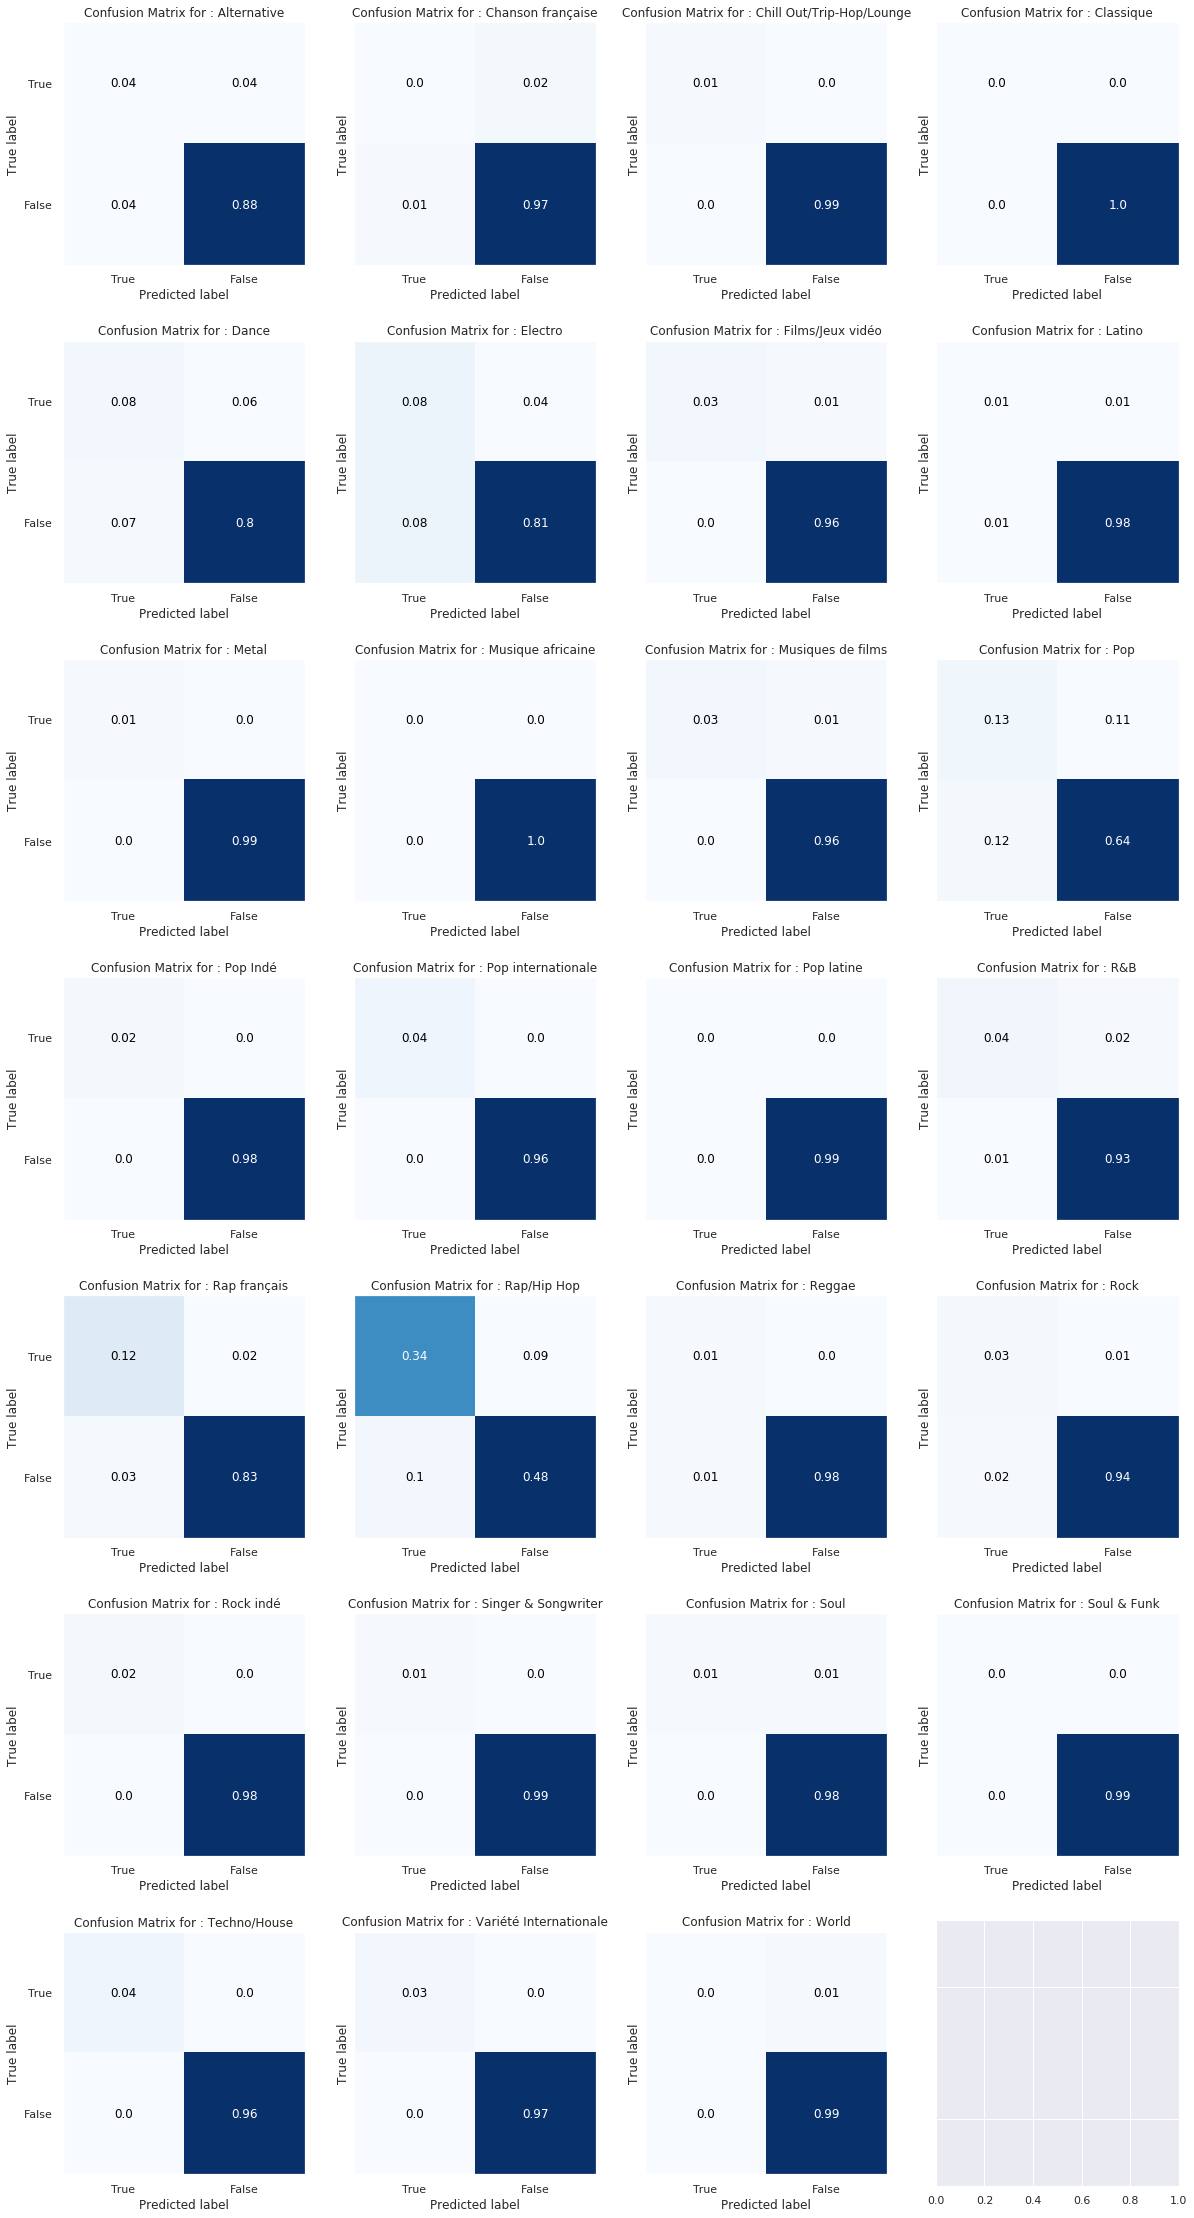

In [ ]:
cms = multilabel_confusion_matrix( Y_test , all_pred )



cmap=plt.cm.Blues

normalize = True 

fig, ax = plt.subplots(nrows=7 , ncols=4 , sharey=True )

fig.set_figwidth(20)
fig.set_figheight(40)


S = 0 
for i in range (7) : 
  for j in range (4) :
    if ( S < 27 ) : 
    
      # Rotations are for visualization because I used to see true positive as a first cell
      cm = np.rot90 ( np.rot90 ( cms[S] ) )
      if normalize:
        cm = cm.astype('float') / cm.sum()
        cm = np.around(cm, decimals=2)
        #pass
      
      thresh = cm.max() / 2.
      im = ax[i][j].imshow(cm, interpolation='nearest', cmap=cmap )
      ax[i][j].grid(False)
      # We want to show all ticks...
      ax[i][j].set(xticks=np.arange(cm.shape[1]),
             yticks=np.arange(cm.shape[0]),
             xticklabels=["True","False"], yticklabels=["True","False"],
             title="Confusion Matrix for : "+dic_labs_mapping[S] ,
             ylabel='True label',
             xlabel='Predicted label' )
      for id1 in range(1,-1,-1) : 
        for id2 in range(1,-1,-1) :
          ax[i][j].text(id2, id1, cm[id1 ,id2] ,
                    ha="center", va="center",
                    color="white" if cm[id1,id2] > thresh else "black")
      S += 1





## Varying Steps from 30 to 300 jump = 10   :

In [ ]:
%%time





MAPs , LabelsMetrics , SamplesMetrics  = list() , list() , list()


for nbSteps in np.array([100]):
  
  
    
    # number of aggregated groups 
    print("step = ",nbSteps)
    stepSize=np.ceil(maxSize/nbSteps)


    # albums index array 
    ialbums=[""]*len(albums.keys())   


    data=np.zeros( ( len(albums.keys()) , nbSteps , len(villes.keys())  ) ,dtype="int16" )


    gc.collect()


    for a in albums :


      ialbums[albums[a]["id"]]=a

      steps=albums[a]["steps"]

      vals= np.zeros( ( nbSteps , len(villes.keys()) ) , dtype="int16" )

      for step in steps :  

        villes_dict =steps[step]

        group = int ( step // stepSize )

        for ville in villes_dict:

          vals[ group , ville ]+= villes_dict[ville]

          data[albums[a]["id"]]=vals




    gc.collect()
    
    
    # data matrix , split train , test 
    labels = df_multi_labels.values
    X_train , Y_train , X_test , Y_test = Custom_Train_Test_Split ( data , labels , training_percent = 0.8  )
    X_train = X_train.reshape ( -1 , len(villes) * nbSteps )
    X_test = X_test.reshape ( -1 , len(villes) * nbSteps )

    print( X_train.shape )
    
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Hyper-parameters 
    input_size = X_train.shape[1] 
    hidden_size = 100 * nbSteps
    num_classes = len(genres)
    num_epochs = 50
    batch_size = 16
    learning_rate = 0.001

    # Creating a custom dataset
    my_dataset = utils.TensorDataset( torch.from_numpy(X_train)
                                     ,torch.from_numpy(Y_train) )

    # Data loader
    train_loader = torch.utils.data.DataLoader(dataset=my_dataset, 
                                               batch_size=batch_size, 
                                               shuffle=True)

    # Fully connected neural network with one hidden layer
    class NeuralNet(nn.Module):

        def __init__(self):
            super(NeuralNet, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size) 
            self.fc2 = nn.Linear(hidden_size, num_classes)  

        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = self.fc2(x)
            return x


    model = NeuralNet().float().to(device)

    # Loss and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam( model.parameters() , lr=learning_rate ) 


    # for loss visualization 
    general_loss = []

    # Train the model
    total_step = len(train_loader)
    for epoch in range(num_epochs):

        for i, (inputs,labels) in enumerate(train_loader):  
            # Move tensors to the configured device
            inputs = inputs.view(-1 ,input_size ).float().to(device)
            labels = labels.view(-1 , num_classes ).float().to(device)

            # Forward pass
            outputs = model(inputs)


            loss = criterion(outputs, labels)
            general_loss.append ( loss )

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        
    
    Threshold = 0.2

    soft_acc , hard_acc , hamming_score , all_pred , real_result = [] , [] , [] , [] , []

    for i in range( X_test.shape[0] ) : 

      res = torch.sigmoid ( model( torch.from_numpy ( X_test[i] ).float().to(device)  ) )


      y_pred = (res > Threshold).cpu().numpy()
      y_true = Y_test[i]


      real_result.append ( res.detach().cpu().numpy() )  
      all_pred.append(y_pred)

      true_args = ( np.argwhere ( y_true == 1 ).flatten() )
      pred_args = ( np.argwhere ( y_pred == 1 ).flatten() )
      
      if ( pred_args.shape[0] == 0 ):
        
        pred_args = np.array ( [torch.max(res, 0)[1].cpu().item()] )
      
      genres_predicted = [ dic_labs_mapping[k]  for k in dic_labs_mapping if k in pred_args ]
      #print("genre predicted example ",i," : ",genres_predicted)
      counts = np.array([1 for y in pred_args if y in true_args ]).sum()
      div = true_args.shape[0]

      soft_acc.append ( counts / div )
      hard_acc.append ( int( np.array_equal( true_args , pred_args ) ) )
      hamming_score.append( len( set(true_args).intersection(set(pred_args)) ) / len(set(true_args).union(set(pred_args))) )


    soft_acc , hard_acc , hamming_score , all_pred , real_result    = \
    np.array(soft_acc) ,  np.array (hard_acc) , np.array(hamming_score) , np.array (all_pred)  , np.array(real_result)

    # soft accuracy : for each example   : count ( using ones in our sparse vectors )  predicted_classes / all_target_classes 



    import warnings
    warnings.filterwarnings('ignore')

    rows = []
    for lab in range( num_classes ) :

      y_true = Y_test[ : , lab ]
      y_pred = all_pred[ : , lab ]
      res =   real_result[: , lab ]

      rows . append ([ dic_labs_mapping[lab] ,
                     precision_score(y_true,y_pred) ,
                     recall_score(y_true,y_pred) ,
                     f1_score(y_true,y_pred) ,
                     average_precision_score(y_true,res)
                     ])


    rows = np.array(rows)

    print("On Test data after Train,Test Split . . . \n")

    stats = rows[:,1:5].astype(float)
    means = np.mean( stats ,  axis=0 )
    
    
    MAPs.append ( round ( means[3] , 2 ) )
    LabelsMetrics.append ( [ round ( means[0] , 2 ) , round ( means[1] , 2 ) ,
                             round ( means[2] , 2 ) ] )
    SamplesMetrics.append ( [ 
                               round(hard_acc.mean(),2) ,
                               round(hamming_score.mean(),2),
                               round(soft_acc.mean(),2)
                             ] )
    
    
    del(data)  
    gc.collect() 


    


step =  100
(1292, 268300)


In [ ]:
MAPs , SamplesMetrics , LabelsMetrics  = np.array(MAPs) , np.array(SamplesMetrics) , np.array(LabelsMetrics)   

MAP :

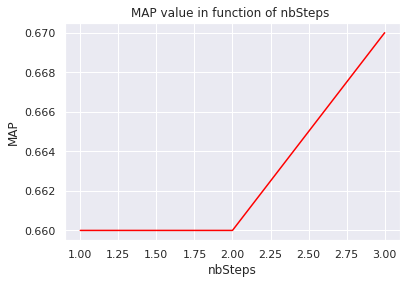

In [ ]:
plt.plot ( np.arange(1,4) , MAPs , 'red' )
plt.title ( "MAP value in function of nbSteps " )
plt.xlabel("nbSteps")
plt.ylabel("MAP")

plt.show()

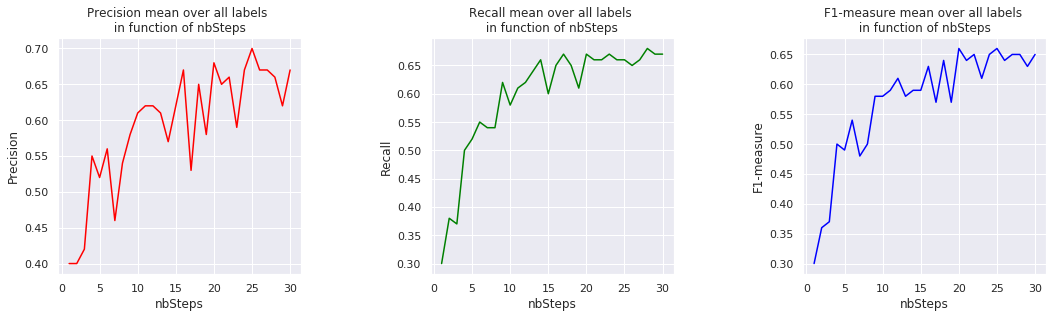

In [ ]:
fig , ax = plt.subplots( nrows=1 , ncols=3 )
headers = ["Precision","Recall","F1-measure"]
colors = ['red','green','blue']
plt.tight_layout()
fig.set_figwidth(16)


for i in range(3) : 
  
  ax[i].plot ( np.arange(1,31) , LabelsMetrics[:,i] , colors[i] )
  ax[i].set_title (headers[i]+" mean over all labels \n in function of nbSteps " )
  ax[i].set_xlabel("nbSteps")
  ax[i].set_ylabel(headers[i])

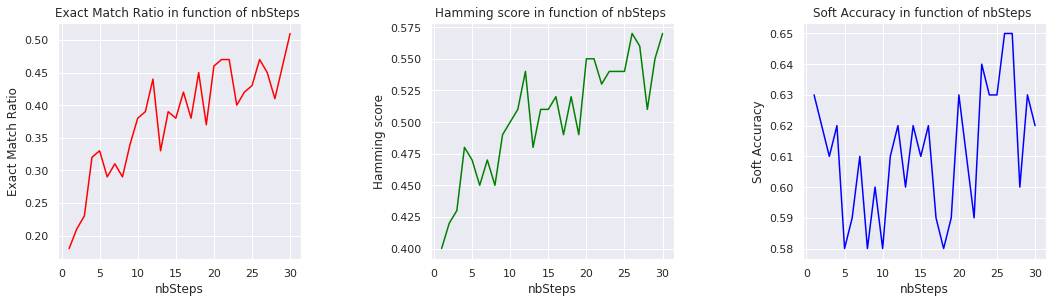

In [ ]:
fig , ax = plt.subplots( nrows=1 , ncols=3 )
headers = ["Exact Match Ratio","Hamming score","Soft Accuracy"]
colors = ['red','green','blue']
plt.tight_layout()
fig.set_figwidth(16)


for i in range(3) : 
  
  ax[i].plot ( np.arange(1,31) , SamplesMetrics[:,i] , colors[i] )
  ax[i].set_title (headers[i]+" in function of nbSteps " )
  ax[i].set_xlabel("nbSteps")
  ax[i].set_ylabel(headers[i])

In [ ]:
print ("best nbSteps for all metrics : ")
print( "MAP : best_nbSteps = ", MAPs.argmax()+1 , " value = " ,
        MAPs[ MAPs.argmax()]  )
print("-----------------------------------------------")
print ( "Precision,Recall,F1 : best_nbSteps = ",(LabelsMetrics.argmax(axis=0))+1,
        "values = \n", LabelsMetrics [ LabelsMetrics.argmax(axis=0) , : ].max(axis=0) )
print("-----------------------------------------------")
print ( "Exact Match , Hamming score , soft accuracy : best_nbSteps = ",(SamplesMetrics.argmax(axis=0))+1,
        "values = \n", SamplesMetrics [ SamplesMetrics.argmax(axis=0) , : ].max(axis=0) )




best nbSteps for all metrics : 
MAP : best_nbSteps =  28  value =  0.68
-----------------------------------------------
Precision,Recall,F1 : best_nbSteps =  [25 28 20] values = 
 [0.7  0.68 0.66]
-----------------------------------------------
Exact Match , Hamming score , soft accuracy : best_nbSteps =  [30 26 26] values = 
 [0.51 0.57 0.65]


## Over-sampling 

# Convolutional Neural Networks 

In [ ]:
labels = df_multi_labels.values

# number of aggregated groups 
nbSteps=28
stepSize=np.ceil(maxSize/nbSteps)


# albums index array 
ialbums=[""]*len(albums.keys())   


data=np.zeros( ( len(albums.keys()) , nbSteps , len(villes.keys())  ) ,dtype="int16" )

    
gc.collect()

2730

In [ ]:
print("Albums ordered Confirmation ( Expected = 1537 ) <=> ( Found =",  ( np.array ( df_multi_labels.index ) == np.array( list(albums.keys()) ) ).sum(),")" )  


Albums ordered Confirmation ( Expected = 1537 ) <=> ( Found = 1537 )


In [ ]:
%%time

for a in albums :
  
  
  ialbums[albums[a]["id"]]=a
  
  steps=albums[a]["steps"]

  vals= np.zeros( ( nbSteps , len(villes.keys()) ) , dtype="int16" )

  for step in steps :  
    
    villes_dict =steps[step]
    
    group = int ( step // stepSize )

    for ville in villes_dict:
      
      vals[ group , ville ]+= villes_dict[ville]
      
      data[albums[a]["id"]]=vals
      
      
X_train , Y_train , X_test , Y_test = Custom_Train_Test_Split ( data , labels , training_percent = 0.8  )

CPU times: user 2.59 s, sys: 92 ms, total: 2.68 s
Wall time: 2.69 s


In [ ]:
X_train.shape

(1292, 28, 2683)

In [ ]:
%%time

import torch.nn.functional as F

torch.manual_seed(0)

gc.collect()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
input_size = X_train.shape[1]
num_classes = len(genres)
num_epochs = 50
batch_size = 20
learning_rate = 0.001

# Creating a custom dataset
my_dataset = utils.TensorDataset( torch.from_numpy(X_train)
                                 ,torch.from_numpy(Y_train) )

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=my_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

CPU times: user 97.4 ms, sys: 43.9 ms, total: 141 ms
Wall time: 216 ms


In [ ]:
from tensorflow import keras 
from tensorflow.keras import layers

img_inputs = keras.Input(shape=( nbSteps , len(villes) , 1))
x = layers.Conv2D(8, (15,15) , activation='relu')(img_inputs)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(256 , activation = 'relu' )(x)
y_hat = layers.Dense(256 )(x)


model = keras.Model(inputs=img_inputs, outputs=y_hat)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40, 2683, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 2669, 8)       1808      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 2667, 16)      1168      
_________________________________________________________________
flatten (Flatten)            (None, 1024128)           0         
_________________________________________________________________
dense (Dense)                (None, 256)               262177024 
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
Total params: 262,245,792
Trainable params: 262,245,792
Non-trainable 

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 15 )
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear( 426240 , 4096 )
        self.fc2 = nn.Linear( 426240 , 128 )
        self.fc3 = nn.Linear(128 , num_classes ) 
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1,5555)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
      


model = Net().float().to(device)      

In [ ]:

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate ) 


# for loss visualization 
general_loss = []

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
  
    for i, (inputs,labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        inputs = inputs.view(-1 , 1 , nbSteps , len(villes) ).float().to(device)
        labels = labels.view(-1 , num_classes ).float().to(device)
        # Forward pass
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        general_loss.append ( loss )
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 50 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 

                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
            
            
            
            
            
plt.figure(figsize=(8,6))
plt.plot(general_loss)
plt.title("Loss function while training ")


plt.show()
      


RuntimeError: ignored

In [ ]:
213120/20

10656.0

In [ ]:

Threshold = 0.3

soft_acc , hard_acc , hamming_score , all_pred , real_result = [] , [] , [] , [] , []

for i in range( X_test.shape[0] ) : 
 
  res = torch.sigmoid ( model( torch.from_numpy ( X_test[i].reshape((1,1,nbSteps,len(villes))) ).float().to(device)  ) )


  y_pred = (res > Threshold).cpu().numpy().ravel()
  y_true = Y_test[i]
  
  real_result.append ( res.detach().cpu().numpy().ravel() )  
  all_pred.append(y_pred)
  
  true_args = ( np.argwhere ( y_true == 1 ).flatten() )
  pred_args = ( np.argwhere ( y_pred == 1 ).flatten() )
  
  
        
  genres_predicted = [ dic_labs_mapping[k]  for k in dic_labs_mapping if k in pred_args ]
  print("genre predicted example ",i," : ",genres_predicted)
  counts = np.array([1 for y in pred_args if y in true_args ]).sum()
  div = true_args.shape[0]
  soft_acc.append ( counts / div )
  hard_acc.append ( int( np.array_equal( true_args , pred_args ) ) )
  hamming_score.append( len( set(true_args).intersection(set(pred_args)) ) / len(set(true_args).union(set(pred_args))) )
  
  
soft_acc , hard_acc , hamming_score , all_pred , real_result    = \
np.array(soft_acc) ,  np.array (hard_acc) , np.array(hamming_score) , np.array (all_pred)  , np.array(real_result)

# soft accuracy : for each example   : count ( using ones in our sparse vectors )  predicted_classes / all_target_classes 


genre predicted example  0  :  ['Dance', 'Electro']
genre predicted example  1  :  ['Rap/Hip Hop']
genre predicted example  2  :  ['Films/Jeux vidéo', 'Musiques de films', 'Soul', 'Soul & Funk']
genre predicted example  3  :  ['Dance', 'Rap/Hip Hop']
genre predicted example  4  :  ['Pop', 'Rap/Hip Hop']
genre predicted example  5  :  ['Rap français', 'Rap/Hip Hop']
genre predicted example  6  :  ['Rap/Hip Hop']
genre predicted example  7  :  ['Pop']
genre predicted example  8  :  ['Dance', 'Electro', 'Techno/House']
genre predicted example  9  :  ['Dance', 'Rap/Hip Hop']
genre predicted example  10  :  ['R&B', 'Rap/Hip Hop']
genre predicted example  11  :  ['Dance']
genre predicted example  12  :  ['Alternative', 'Pop Indé', 'Rock', 'Rock indé']
genre predicted example  13  :  ['Pop', 'Rock']
genre predicted example  14  :  ['Rap/Hip Hop']
genre predicted example  15  :  ['Rap français', 'Rap/Hip Hop']
genre predicted example  16  :  []
genre predicted example  17  :  ['Rap français', 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

rows = []
for lab in range( num_classes ) :
  
  y_true = Y_test[ : , lab ]
  y_pred = all_pred[ : , lab ]
  res =   real_result[: , lab ]
  rows . append ([ dic_labs_mapping[lab] ,
                 round ( precision_score(y_true,y_pred) , 2 ) ,
                 round ( recall_score(y_true,y_pred) , 2 )  ,
                 round ( f1_score(y_true,y_pred) , 2 )  ,
                 round ( average_precision_score(y_true,res) , 2 )
                 ])


  
rows = np.array(rows)

from IPython.display import display


metrics = pd.DataFrame(rows[ : , 1: ] , index=rows[:,0] , columns=[ 'Precision\
                     (K=27) ' , 'Recall (K=27) ' , 'F1-score (K=27) ' ,"AvgP" ])
display(metrics)


print("On Test data after Train,Test Split . . . \n")

stats = rows[:,1:5].astype(float)
means = np.mean( stats ,  axis=0 )
print("\n-----------------------")
print("metrics on labels : ")
print("-----------------------")
print("MAP : ",round ( means[3] , 2 ))
print ( "Precision macro : ",round ( means[0] , 2 ) ) 
print ( "Recall macro : ", round ( means[1] , 2 ) )
print ( "F1-score macro : ", round ( means[2] , 2 ) )
print("-----------------------")
print("metrics on samples : ")
print("-----------------------")
print('Hamming loss: ' , round(hamming_loss(Y_test, all_pred),2) )
print('Exact match ratio : ',round(hard_acc.mean(),2) )
print('Hamming score : ' , round(hamming_score.mean(),2) )
print('soft accuracy : ',round(soft_acc.mean(),2) )

,Precision (K=27),Recall (K=27),F1-score (K=27),AvgP
Alternative,0.35,0.45,0.39,0.45
Chanson française,1.0,0.12,0.22,0.18
Chill Out/Trip-Hop/Lounge,1.0,0.5,0.67,0.7
Classique,0.0,0.0,0.0,0.02
Dance,0.6,0.7,0.65,0.6
Electro,0.71,0.55,0.62,0.59
Films/Jeux vidéo,0.86,0.86,0.86,0.7
Latino,0.8,0.57,0.67,0.62
Metal,0.5,0.67,0.57,0.81
Musique africaine,0.0,0.0,0.0,0.02


On Test data after Train,Test Split . . . 


-----------------------
metrics on labels : 
-----------------------
MAP :  0.63
Precision macro :  0.7
Recall macro :  0.61
F1-score macro :  0.63
-----------------------
metrics on samples : 
-----------------------
Hamming loss:  0.04
Exact match ratio :  0.44
Hamming score :  0.52
soft accuracy :  0.58


# Autre approche du problème de classification de genre

In [ ]:
import torch.utils.data as utils
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

pd.options.display.max_columns = 999

In [ ]:
df_labels = pd.read_json ('../deezer_data/album_genres_new_releases.json' , lines = True )
df_data = pd.read_json ('../deezer_data/sampled_geoloc_counters_new_releases.json' , lines = True )

In [ ]:
df_data['d']=pd.to_datetime(df_data['d'], format='%Y%m%d', errors='ignore')

In [ ]:
labels_count = df_labels.groupby('genre_name').count()
genres_remove = set(labels_count.loc[labels_count['album_id']<5].reset_index()['genre_name'])
print(genres_remove)

album_remove = set(df_labels.loc[df_labels['genre_name'].isin(genres_remove)]['album_id'])
df_labels = df_labels.loc[~df_labels['album_id'].isin(album_remove)]

df_data = df_data.loc[~df_data['album_id'].isin(album_remove)]

In [ ]:
def transformAlbumData(df_datax, cities, nbTemps, interJours):
    
    #Récupération de la date de sortie de l'album sur deezer
    date_sortie=df_datax.sort_values(by='d').iloc[0]['d']
    datax=np.zeros((nbTemps,len(cities)))
    #Pour chaque pas de temps de (interJours) jours et villes, on compte le nombre d'écoutes.
    for i in range(nbTemps): 
        date_inf=date_sortie+pd.Timedelta(days=i*interJours)
        date_sup=date_sortie+pd.Timedelta(days=(i+1)*interJours)
        #On récupère toutes les données compris entre la date date_inf et date_sup
        df_temps=df_datax.query('d >= @date_inf and d < @date_sup')
        #On regroupe par villes
        df_temps=df_temps.groupby(['loc_city']).sum()

        for city in df_temps.index.values:
            #On stocke les valeurs pour chaque pays dans un tableau numpy.
            j=np.argwhere(cities==city)[0][0]
            datax[i,j]=df_temps.loc[city]['nstreams']
    """   
    #On fait de même pour le restes des données qui n'ont pas été inclus dans les pas de temps
    df_temps=df_datax.loc[(df_datax['d']>=date_sortie+pd.Timedelta(days=nbTemps*interJours))]
    df_temps=df_temps.groupby(['loc_city']).sum()
    
    for city in df_temps.index.values:
        j=np.argwhere(cities==city)[0][0]
        datax[i,j]=df_temps.loc[city]['nstreams']
    """      
    return datax

In [ ]:
cities=np.array(sorted(set(df_data['loc_city'])))
g=np.array(sorted(set(df_labels['genre_name'])))

genres_ind=dict()
for i in range(len(g)):
    genres_ind[g[i]]=i

In [ ]:
def transformAllAlbumData(df_datax,df_datay,nbTemps,interJours):
    
    #nbtemps = nombre de pas de temps
    #interJours = nombre de jours d'un pas de temps
    
    df_count = df_datay.groupby('genre_name').count()
    max_count = df_count.max()['album_id']
    
    albumIds=np.array(sorted(set(df_datay['album_id'])))

    datax=[]
    datay=[]
    
    for i in range(len(albumIds)):
        genres_album = set(df_datay.loc[df_datay['album_id']==albumIds[i]]['genre_name'])
        
        x = transformAlbumData(df_datax.loc[df_datax['album_id']==albumIds[i]], cities, nbTemps, interJours)
        y = np.zeros(len(g))
        for genre in genres_album:
            y[genres_ind[genre]]=1

        k = np.min([df_count.loc[genre] for genre in genres_album])
            
        for resample in range(int(max_count/k)):
            datax.append(x)
            datay.append(y)

    return np.array(datax), np.array(datay)

In [ ]:
datax, datay = transformAllAlbumData(df_data, df_labels, 1, 120)

### Séparation des données en données d'apprentissage et données de validation

In [ ]:
def split_dataset(datax,datay,prc,shuffle=True):
    
    indices = list(range(len(datax)))
    split = int(np.floor(prc*len(datax)))
    if shuffle==True:
        np.random.seed(42)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]
    
    return datax[train_indices], datay[train_indices], datax[val_indices], datay[val_indices]

trainx, trainy, valx, valy = split_dataset(datax,datay,0.4,True)

### Définition du réseau de neurones

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(dim, 50)
        self.fc3 = nn.Linear(50, nbLabel)

    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = self.fc3(x)
        
        return F.sigmoid(x)



net = Net()
print(net)

In [ ]:
batch_size=50
dim=trainx.shape[2]
print(trainx.shape,trainy.shape,valx.shape,valy.shape)
nbLabel=trainy.shape[1]

### Conversion des données d'apprentissage en type tensor

In [ ]:
device = torch.device('cpu')

train_inputs=torch.as_tensor(trainx).float()
train_labels=torch.as_tensor(trainy).float()


# Creating a custom dataset
my_dataset = utils.TensorDataset( train_inputs ,train_labels )

# Data loader
train_loader = utils.DataLoader(dataset=my_dataset, batch_size=batch_size, shuffle=True)


criterion=nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001 )

### Apprentissage des données

In [ ]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, (inputs,labels) in enumerate(train_loader):
        # get the inputs
        inputs = inputs.view(-1 ,dim ).to(device)
        labels = labels.view(-1 , nbLabel ).to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        
        # print statistics
        running_loss += loss.item()
        if i % 40 == 39:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 40))
            running_loss = 0.0

        
print('Finished Training')

### Mean average presicion de notre modèle sur les données de validation

In [ ]:
val_inputs=torch.as_tensor(valx).float()
val_labels=torch.as_tensor(valy).float()


AP = 0.0
total = 0.0
with torch.no_grad():
    for i in range(int(val_inputs.size(0))):
        input, label = val_inputs[i], val_labels[i]
        output = net(input)
        output = output.squeeze()
        
        _,predicted = torch.sort(-output)
        precision = 0
        for i in range(len(predicted)):
            precision += float(label[predicted[i]].item()/(i+1))
            
        AP += precision/label.sum().item()
        total += 1

print('Mean Average precision of the network: %d %%' % (
    100 * AP / total))

### Mean average presicion de notre modèle sur les données d'apprentissage

In [ ]:
AP = 0.0
total = 0.0
with torch.no_grad():
    for i in range(int(train_inputs.size(0))):
        input, label = train_inputs[i], train_labels[i]
        output = net(input)
        output = output.squeeze()
        
        _,predicted = torch.sort(-output)
        
        precision = 0
        for i in range(len(predicted)):
            precision += float(label[predicted[i]].item()/(i+1))
            
        AP += precision/label.sum().item()
        total += 1

print('Mean Average precision of the network: %d %%' % (
    100 * AP / total))

## Prise en compte de l'aspect temporel des données

In [ ]:
datax, datay = transformAllAlbumData(df_data, df_labels, 3, 20)
del df_data
del df_labels

In [ ]:
trainx, trainy, valx, valy = split_dataset(datax,datay,0.2,True)

In [ ]:
batch_size=50
dim=trainx.shape[2]
print(trainx.shape,trainy.shape,valx.shape,valy.shape)
nbLabel=trainy.shape[1]

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # an affine operation: y = Wx + b
        self.conv1 = nn.Conv2d(1,6,3)
        self.pool = nn.MaxPool2d(3, 3)
        self.fc = nn.Linear(50, nbLabel)

    def forward(self, x):
        
        x = torch.unsqueeze(x,1)
        x = self.pool(F.relu(self.conv1(x)))
        nbr_features = self.num_flat_features(x)
        x = x.view(-1, nbr_features)
        x = torch.relu(nn.Linear(nbr_features,50)(x))
        x = self.fc(x)
        return F.sigmoid(x)

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features



### Conversion des données d'apprentissage en type tensor

In [ ]:
device = torch.device('cpu')
net = Net().to(device)
train_inputs=torch.as_tensor(trainx).float()
train_labels=torch.as_tensor(trainy).float()



# Creating a custom dataset
my_dataset = utils.TensorDataset( train_inputs ,train_labels )

# Data loader
train_loader = utils.DataLoader(dataset=my_dataset, batch_size=batch_size, shuffle=True)

criterion=nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001 )

### Apprentissage des données

In [ ]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, (inputs,labels) in enumerate(train_loader):
        # get the inputs
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        outputs = outputs.squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 40 == 39:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 40))
            running_loss = 0.0

print('Finished Training')

### Mean average presicion de notre modèle sur les données de validation

In [ ]:
val_inputs=torch.as_tensor(valx).float()
val_labels=torch.as_tensor(valy).float()

AP = 0.0
total = 0.0
with torch.no_grad():
    for i in range(int(val_inputs.size(0))):
        input, label = val_inputs[i], val_labels[i]
        output = net(torch.unsqueeze(input,0))
        output = output.squeeze()
        
        _,predicted = torch.sort(-output)
        precision = 0
        for i in range(len(predicted)):
            precision += float(label[predicted[i]].item()/(i+1))
            
        AP += precision/label.sum().item()
            
        total += 1

print('Mean Average precision of the network: %d %%' % (
    100 * AP / total))

### Mean average presicion de notre modèle sur les données d'apprentissage

In [ ]:
AP = 0.0
total = 0.0
with torch.no_grad():
    for i in range(int(train_inputs.size(0))):
        input, label = train_inputs[i], train_labels[i]
        output = net(torch.unsqueeze(input,0))
        output = output.squeeze()
        
        _,predicted = torch.sort(-output)
        precision = 0
        for i in range(len(predicted)):
            precision += float(label[predicted[i]].item()/(i+1))
            
        AP += precision/label.sum().item()
            
        total += 1

print('Mean Average precision of the network: %d %%' % (
    100 * AP / total))